### Exercício 01

![alt text](ex1.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class Atomo:
    def __init__(self, massa: float):
        self.massa = massa

class CadeiaAtomica:
    def __init__(self, N: int, tipo: str = 'homogenea', k: float = 1.0):
        self.N = N
        self.k = k
        self.tipo = tipo.lower()
        self.atom_list = self._criar_cadeia()
        self.massas = [atomo.massa for atomo in self.atom_list]

    def _criar_cadeia(self):
        atomos = []
        m = 1.0
        if self.tipo == 'homogenea':
            for _ in range(self.N):
                atomos.append(Atomo(m))
        elif self.tipo == 'ternaria':
            pattern = [m, 3*m, 5*m]
            for i in range(self.N):
                atomos.append(Atomo(pattern[i % 3]))
        else:
            raise ValueError("Tipo de cadeia inválido. Use 'homogenea' ou 'ternaria'.")
        return atomos

    def montar_matrizes(self):
        M = np.diag(self.massas)
        K = np.zeros((self.N, self.N))
        for i in range(self.N):
            K[i, i] += 2 * self.k
            K[i, (i - 1) % self.N] -= self.k
            K[i, (i + 1) % self.N] -= self.k
        return M, K

    def calcular_frequencias_e_modos(self):
        M, K = self.montar_matrizes()
        A = np.linalg.inv(M) @ K
        eigvals, eigvecs = np.linalg.eig(A)

        idx = np.argsort(np.real(eigvals))
        eigvals = np.real(eigvals[idx])
        eigvecs = np.real(eigvecs[:, idx])
        freq = np.sqrt(np.abs(eigvals))

        return freq, eigvecs

    def plotar_frequencias(self, freq):
        plt.figure(figsize=(8, 4))
        plt.plot(range(1, len(freq)+1), freq, marker='o')
        plt.title(f"Frequências Naturais - {self.tipo.capitalize()} (N={self.N})")
        plt.xlabel("Modo")
        plt.ylabel("Frequência (rad/s)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plotar_modos_normais(self, modos, freq, n_modos=3):
        plt.figure(figsize=(10, 6))
        for i in range(n_modos):
            desloc = modos[:, i]
            desloc = desloc / np.max(np.abs(desloc))  # Normalizar
            plt.subplot(n_modos, 1, i+1)
            plt.plot(range(self.N), desloc, marker='o')
            plt.title(f"Modo {i+1} - Freq: {freq[i]:.2f} rad/s")
            plt.xlabel("Índice do Átomo")
            plt.ylabel("Deslocamento")
            plt.grid(True)
        plt.tight_layout()
        plt.show()



===== N = 100, Tipo = homogenea =====
Primeiras 5 frequências: [6.32464637e-08 6.28215182e-02 6.28215182e-02 1.25581039e-01
 1.25581039e-01]


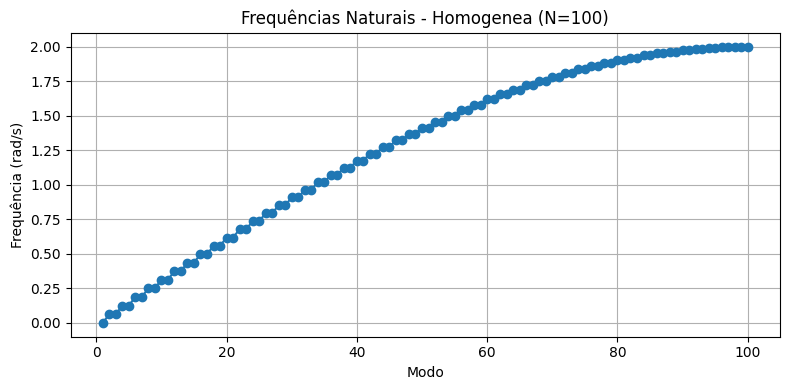

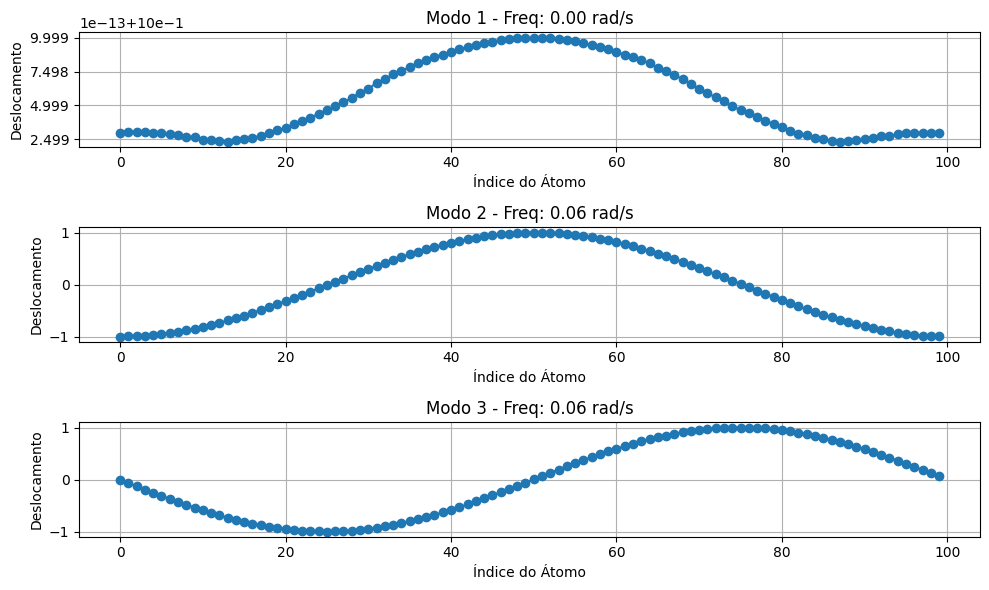


===== N = 100, Tipo = ternaria =====
Primeiras 5 frequências: [5.47868943e-09 3.62625078e-02 3.65063707e-02 7.24437566e-02
 7.29338994e-02]


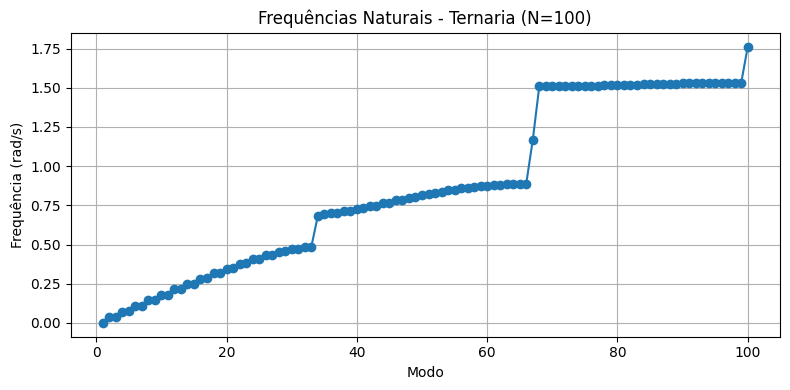

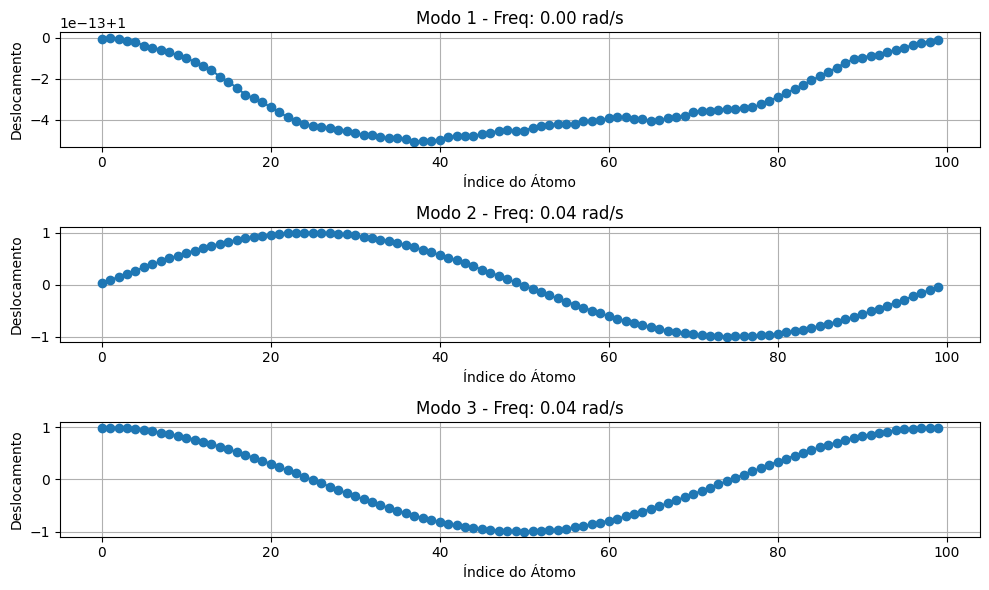


===== N = 1000, Tipo = homogenea =====
Primeiras 5 frequências: [1.31415234e-07 6.28317497e-03 6.28317497e-03 1.25662879e-02
 1.25662879e-02]

===== N = 1000, Tipo = ternaria =====
Primeiras 5 frequências: [4.83929436e-09 3.62758565e-03 3.63000570e-03 7.25509280e-03
 7.25993314e-03]

===== N = 10000, Tipo = homogenea =====
Primeiras 5 frequências: [0.         0.00062832 0.00062832 0.00125664 0.00125664]

===== N = 10000, Tipo = ternaria =====
Primeiras 5 frequências: [0.         0.00036276 0.00036278 0.00072552 0.00072557]


In [2]:
# Exemplo de uso
from frequencia import CadeiaAtomica


Ns = [100, 1000, 10000]
tipos = ['homogenea', 'ternaria']
k = 1.0

for N in Ns:
    for tipo in tipos:
        print(f"\n===== N = {N}, Tipo = {tipo} =====")
        sistema = CadeiaAtomica(N=N, tipo=tipo, k=k)
        freq, modos = sistema.calcular_frequencias_e_modos()
        print("Primeiras 5 frequências:", freq[:5])

        if N == 100:
            sistema.plotar_frequencias(freq)
            sistema.plotar_modos_normais(modos, freq, n_modos=3)


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh  # Mais eficiente para problemas simétricos generalizados

# Classe que representa a cadeia atômica
class CadeiaAtomica:
    def __init__(self, N: int, tipo: str = 'homogenea', k: float = 1.0):
        self.N = N               # Número de átomos na cadeia
        self.k = k               # Constante elástica das molas
        self.tipo = tipo.lower()  # Tipo da cadeia ('homogenea' ou 'ternaria')
        self.massas = self._gerar_massas()  # Vetor com as massas dos átomos

    def _gerar_massas(self):
        m = 1.0  # Massa base
        if self.tipo == 'homogenea':
            return np.full(self.N, m)
        elif self.tipo == 'ternaria':
            # Alternância m, 3m, 5m, m, 3m, 5m, ...
            pattern = [m, 3*m, 5*m]
            return np.array([pattern[i % 3] for i in range(self.N)])
        else:
            raise ValueError("Tipo inválido. Use 'homogenea' ou 'ternaria'.")

    def montar_matrizes(self):
        # Matriz de massa (diagonal)
        M = np.diag(self.massas)

        # Matriz de rigidez K com condições de contorno periódicas (circular)
        K = np.zeros((self.N, self.N))
        for i in range(self.N):
            K[i, i] = 2 * self.k
            K[i, (i + 1) % self.N] = -self.k
            K[i, (i - 1) % self.N] = -self.k

        return M, K

    def calcular_frequencias_e_modos(self):
        M, K = self.montar_matrizes()

        # Resolve o problema generalizado: K x = λ M x
        eigvals, eigvecs = eigh(K, M)

        # Remove valores negativos e ordena
        eigvals = np.clip(eigvals, 0, None)
        freq = np.sqrt(eigvals)

        return freq, eigvecs

    def plotar_frequencias(self, freq):
        plt.figure(figsize=(8, 4))
        plt.plot(freq, '.', markersize=4)
        plt.title(f"Frequências Naturais - {self.tipo.capitalize()} (N={self.N})")
        plt.xlabel("Modo")
        plt.ylabel("Frequência (rad/s)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plotar_modos_normais(self, modos, freq, n_modos=3):
        plt.figure(figsize=(10, 6))
        for i in range(n_modos):
            desloc = modos[:, i]
            desloc /= np.max(np.abs(desloc))  # Normaliza o deslocamento
            plt.subplot(n_modos, 1, i + 1)
            plt.plot(desloc, marker='o')
            plt.title(f"Modo {i + 1} - Freq: {freq[i]:.4f} rad/s")
            plt.xlabel("Índice do Átomo")
            plt.ylabel("Deslocamento")
            plt.grid(True)
        plt.tight_layout()
        plt.show()



===== N = 100, Tipo = homogenea =====
Primeiras 5 frequências: [0.         0.06282152 0.06282152 0.12558104 0.12558104]


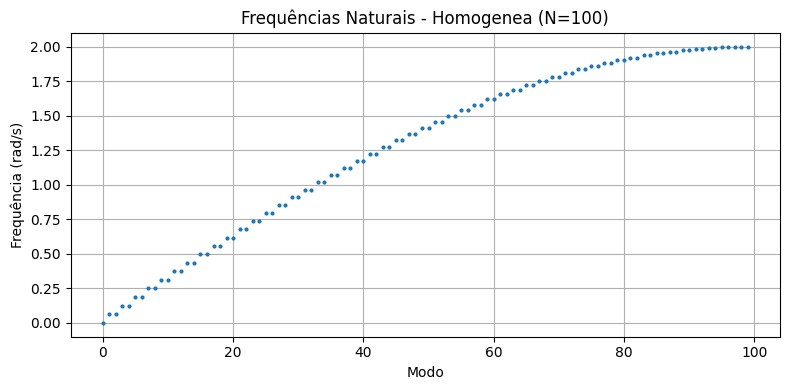

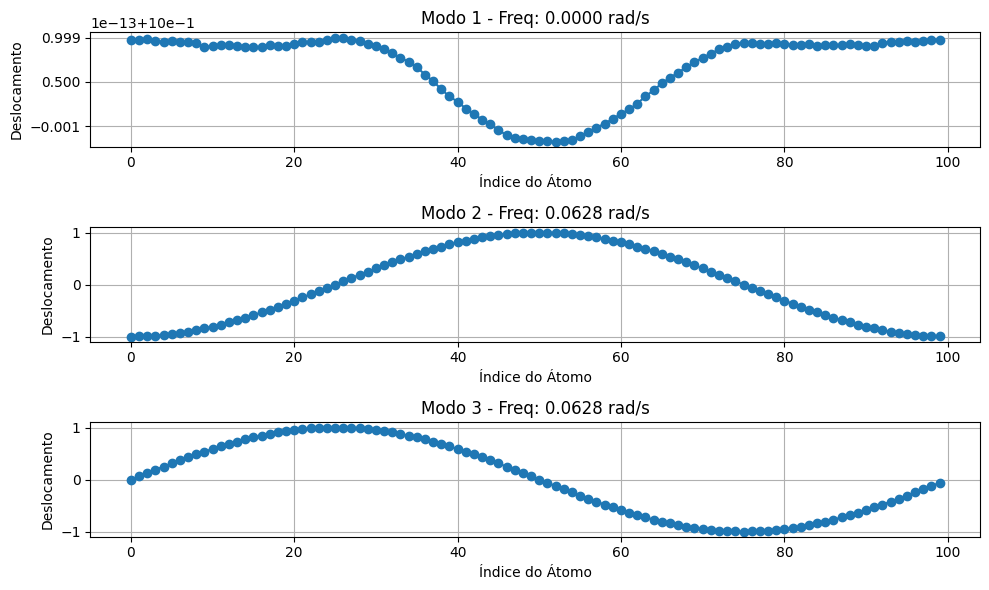


===== N = 100, Tipo = ternaria =====
Primeiras 5 frequências: [0.         0.03626251 0.03650637 0.07244376 0.0729339 ]


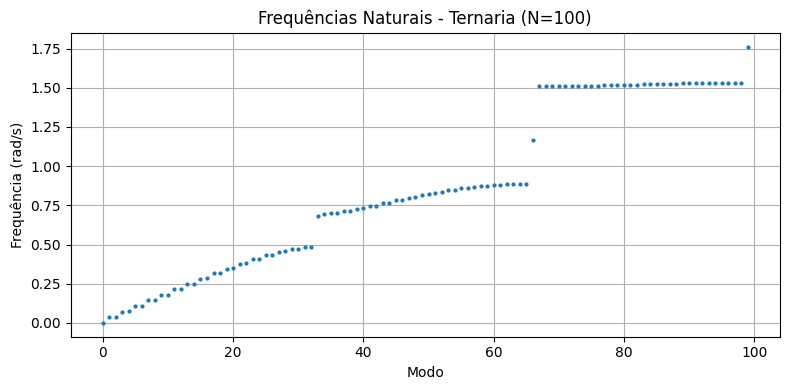

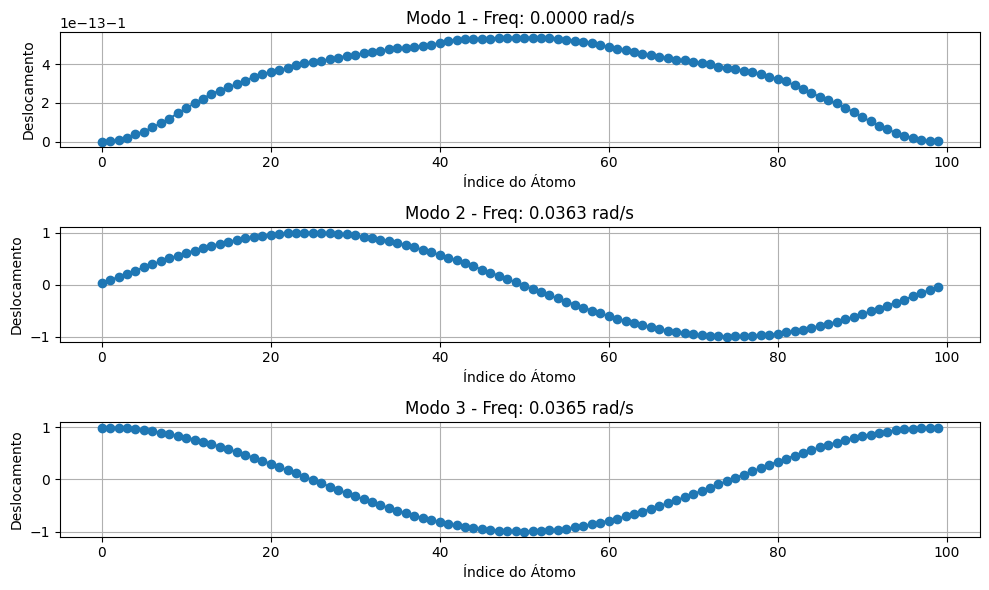


===== N = 1000, Tipo = homogenea =====
Primeiras 5 frequências: [2.52890835e-08 6.28317497e-03 6.28317497e-03 1.25662879e-02
 1.25662879e-02]


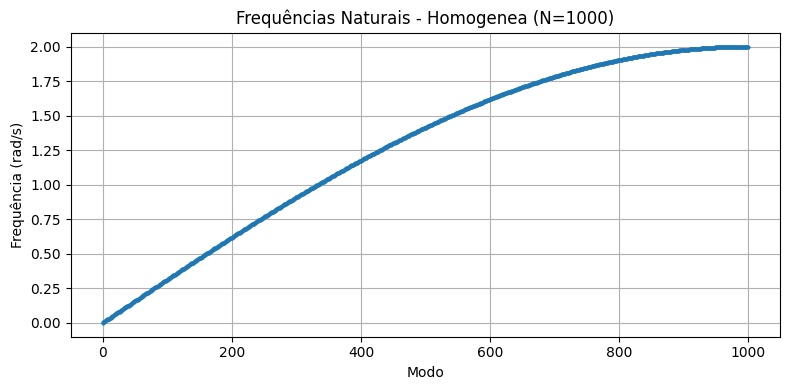

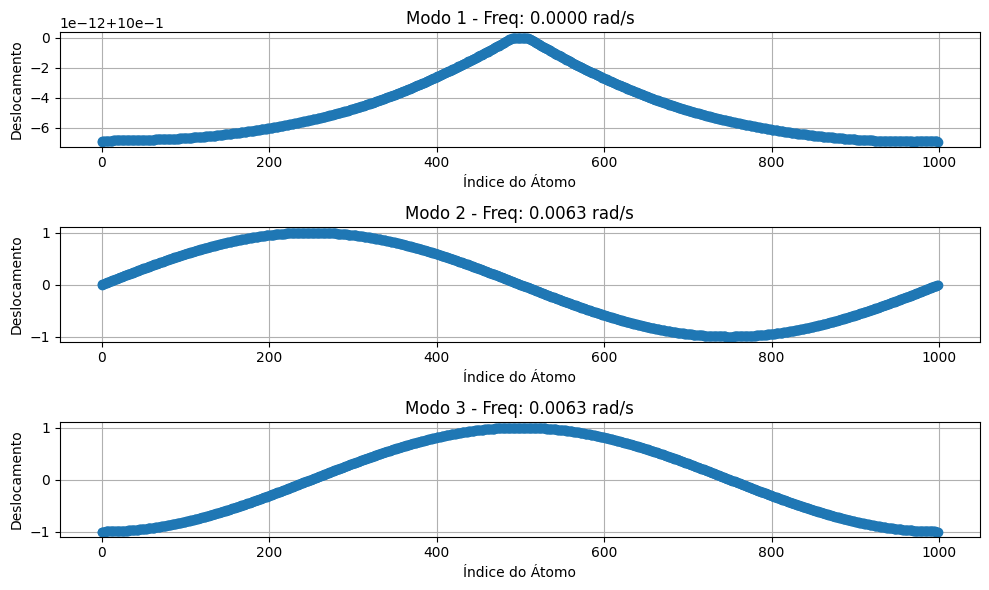


===== N = 1000, Tipo = ternaria =====
Primeiras 5 frequências: [0.         0.00362759 0.00363001 0.00725509 0.00725993]


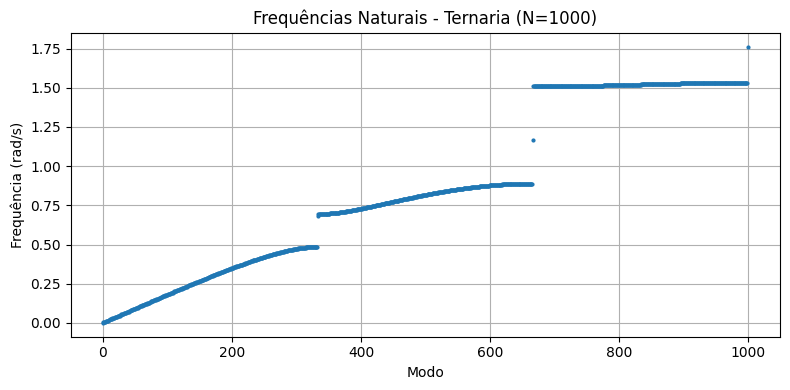

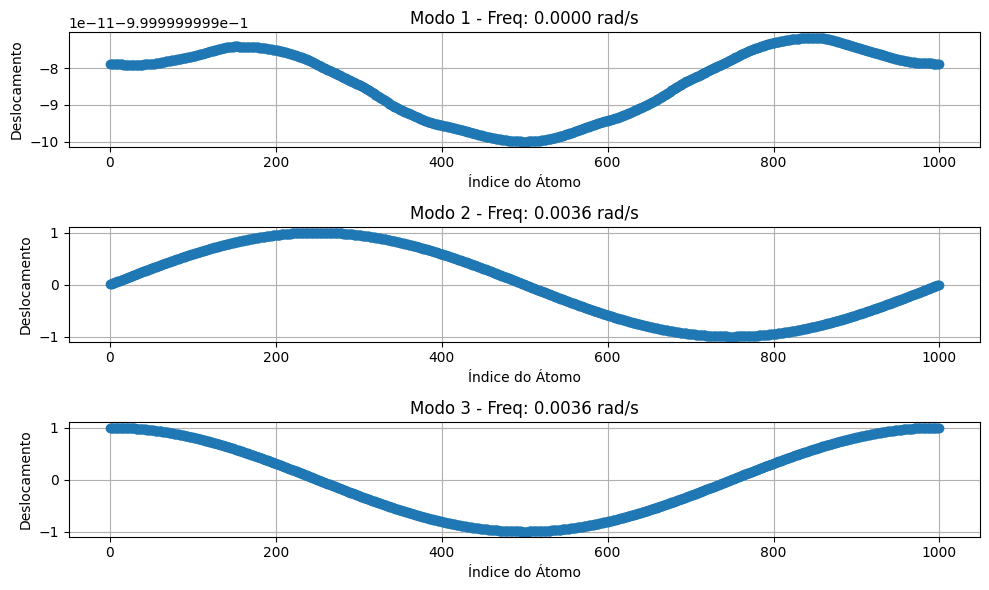


===== N = 10000, Tipo = homogenea =====
Primeiras 5 frequências: [1.41134000e-08 6.28318520e-04 6.28318521e-04 1.25663698e-03
 1.25663698e-03]


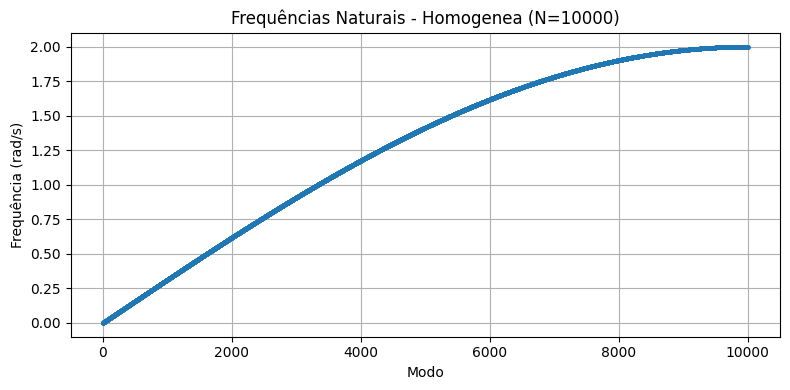

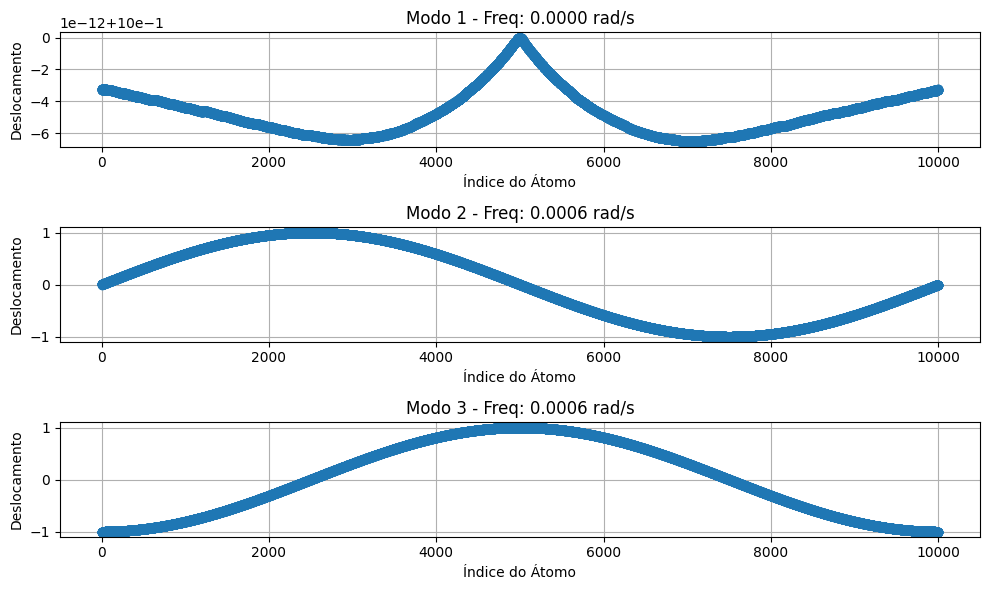


===== N = 10000, Tipo = ternaria =====
Primeiras 5 frequências: [0.         0.00036276 0.00036278 0.00072552 0.00072557]


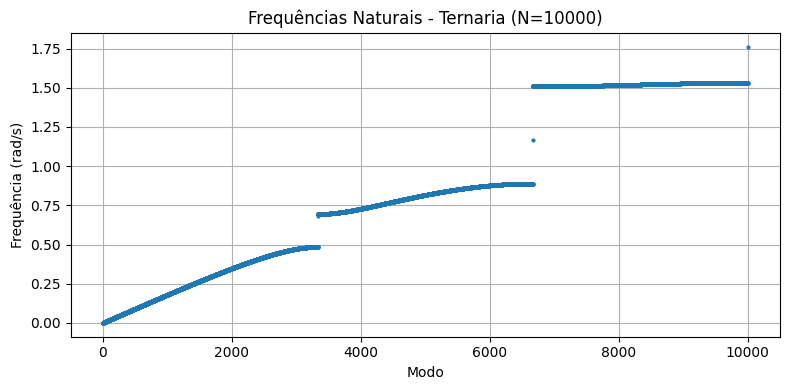

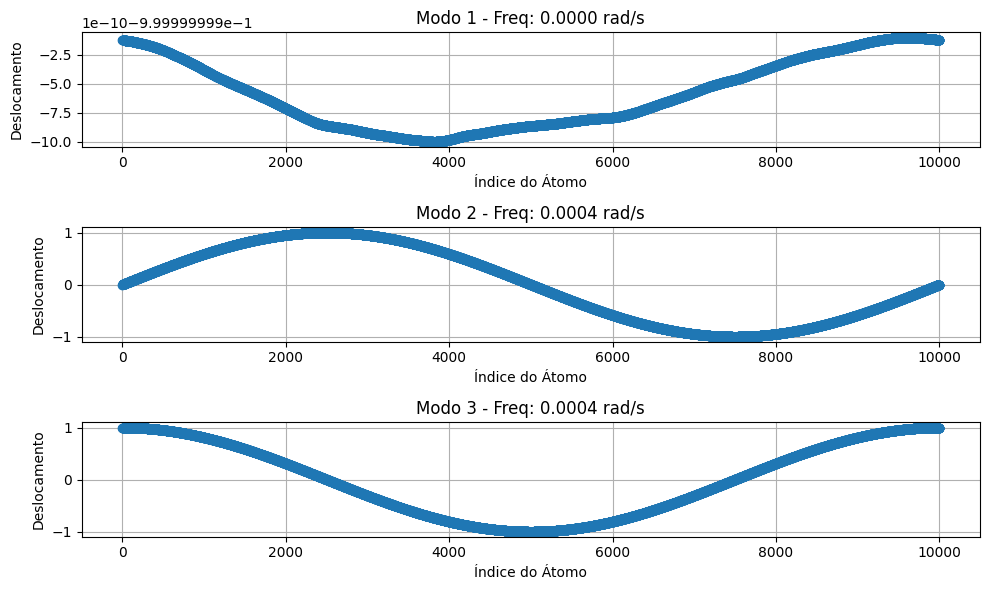

In [7]:
Ns = [100, 1000, 10000]
tipos = ['homogenea', 'ternaria']

for N in Ns:
    for tipo in tipos:
        print(f"\n===== N = {N}, Tipo = {tipo} =====")
        sistema = CadeiaAtomica(N=N, tipo=tipo, k=1.0)
        freq, modos = sistema.calcular_frequencias_e_modos()
        print("Primeiras 5 frequências:", freq[:5])

        # Plota todas as frequências
        sistema.plotar_frequencias(freq)

        # Plota os 3 primeiros modos completos SEM corte
        sistema.plotar_modos_normais(modos, freq, n_modos=3)

### Exercício 02
![alt text](ex2.png)

In [8]:
def plotar_densidade_de_estados(freq_hom, freq_tern, N, bins=100):
    plt.figure(figsize=(10, 5))

    # Histograma normalizado da homogênea
    plt.hist(freq_hom, bins=bins, alpha=0.6, density=True, label='Homogênea', color='blue')

    # Histograma normalizado da ternária
    plt.hist(freq_tern, bins=bins, alpha=0.6, density=True, label='Ternária', color='orange')

    plt.title(f"Densidade de Estados - N = {N}")
    plt.xlabel("Frequência (rad/s)")
    plt.ylabel("Densidade")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


===== N = 100 =====
Homogênea - Primeiras 5 frequências: [0.         0.06282152 0.06282152 0.12558104 0.12558104]
Ternária - Primeiras 5 frequências: [0.         0.03626251 0.03650637 0.07244376 0.0729339 ]


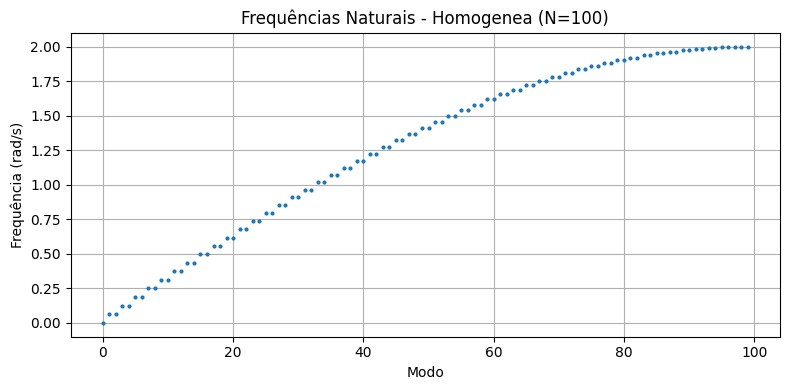

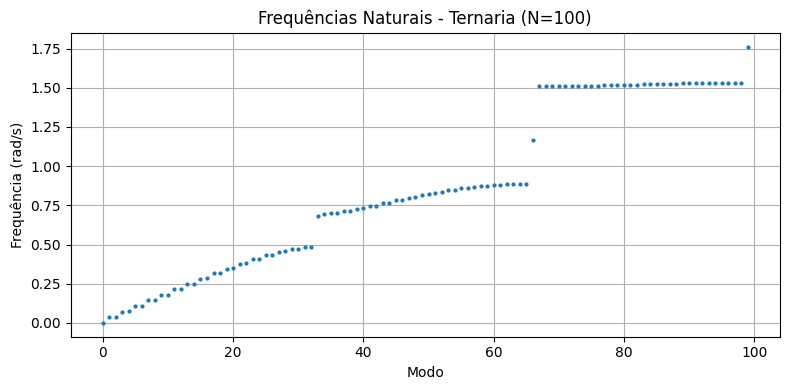

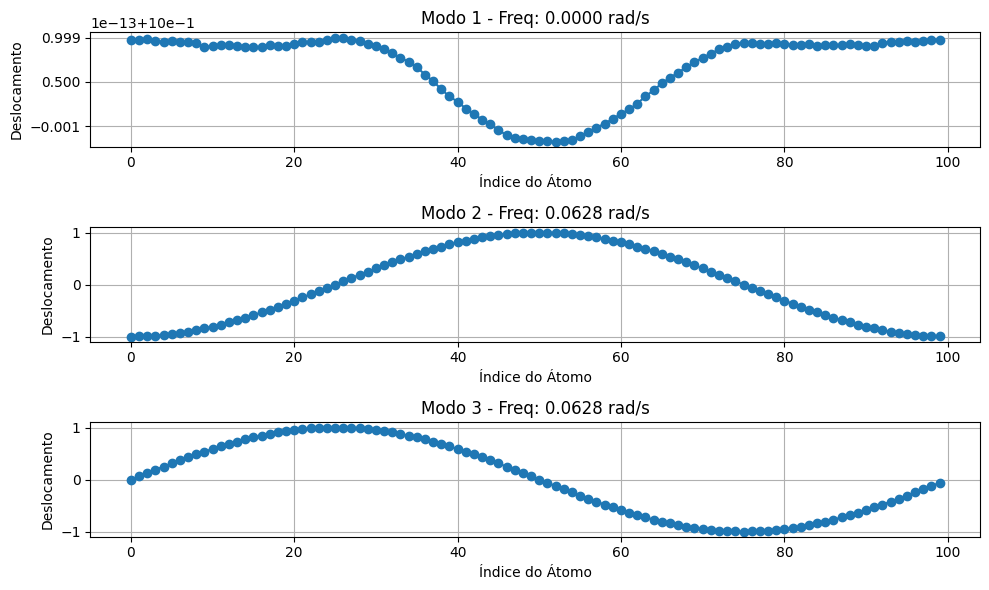

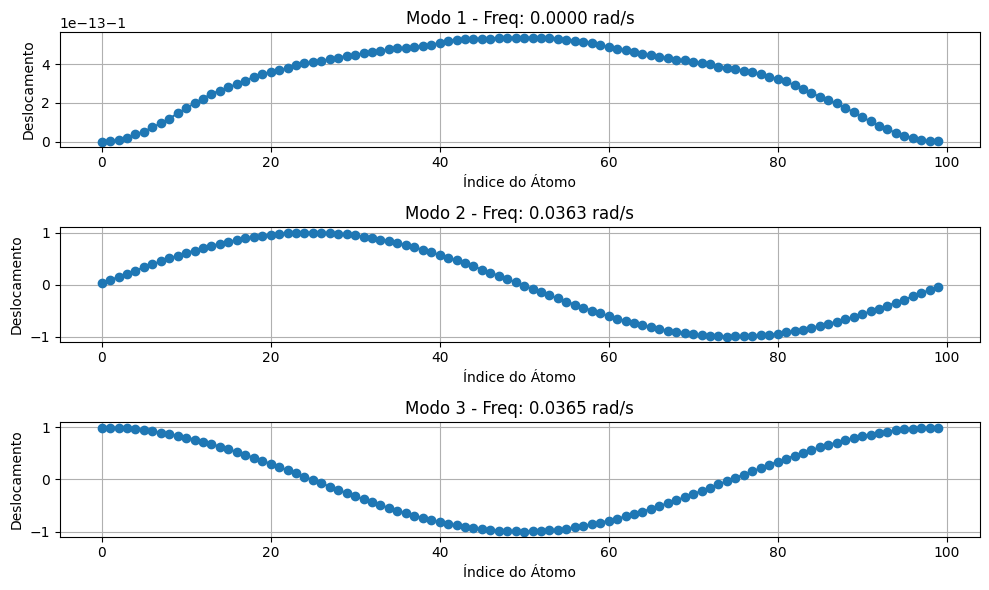

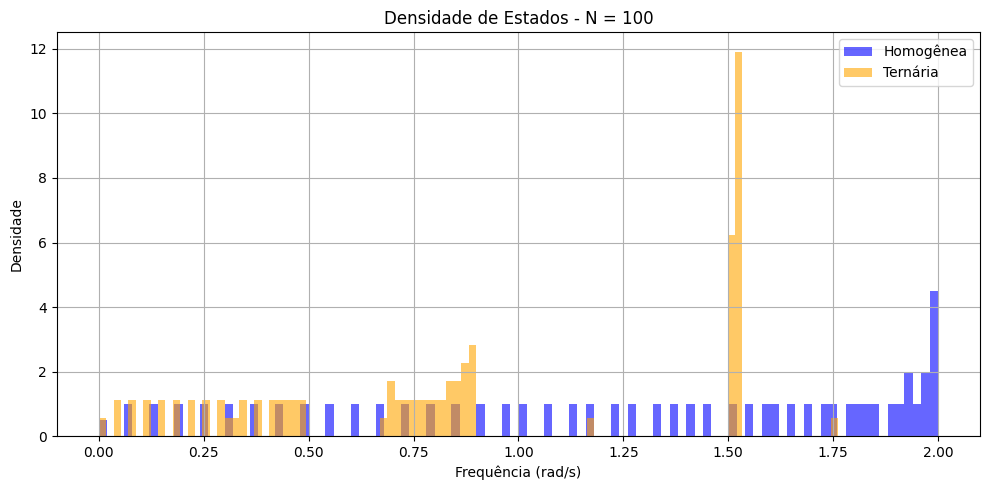


===== N = 1000 =====
Homogênea - Primeiras 5 frequências: [2.52890835e-08 6.28317497e-03 6.28317497e-03 1.25662879e-02
 1.25662879e-02]
Ternária - Primeiras 5 frequências: [0.         0.00362759 0.00363001 0.00725509 0.00725993]


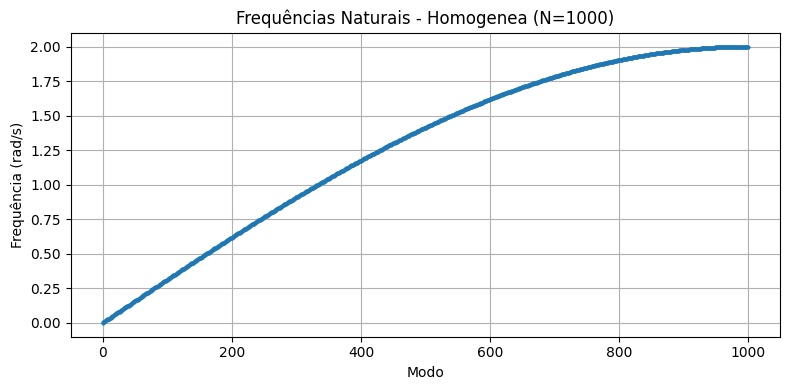

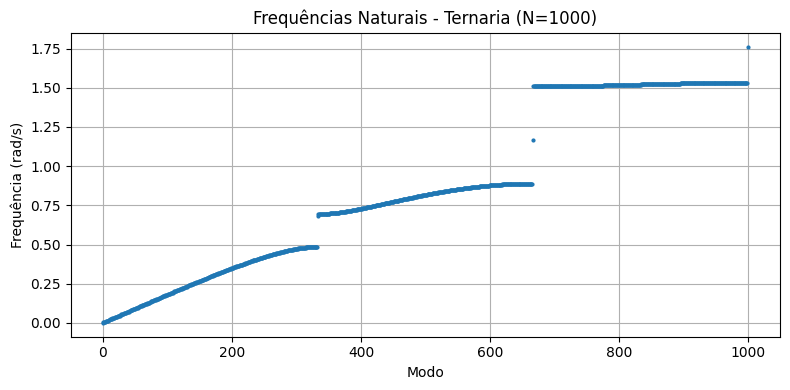

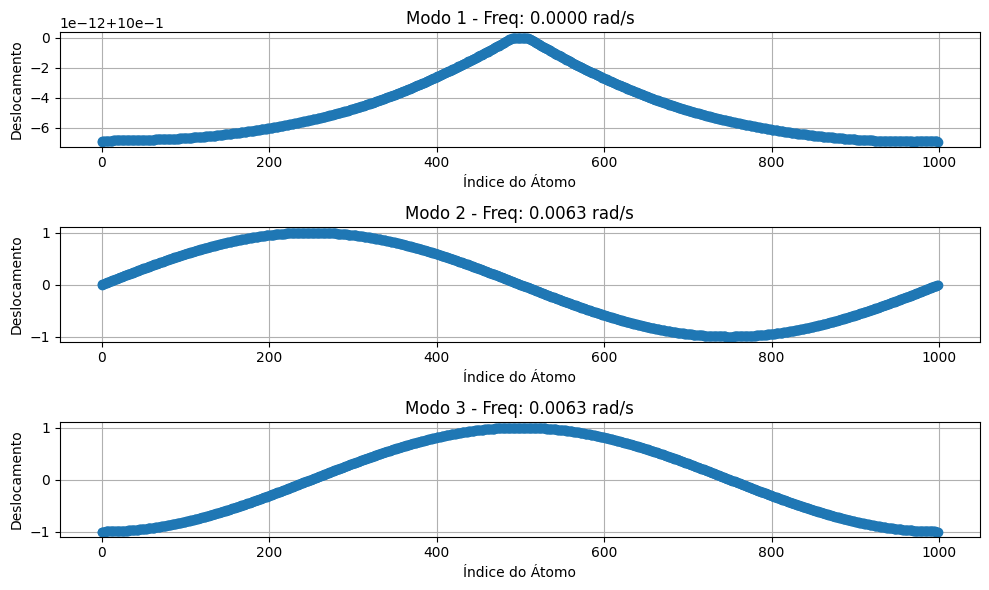

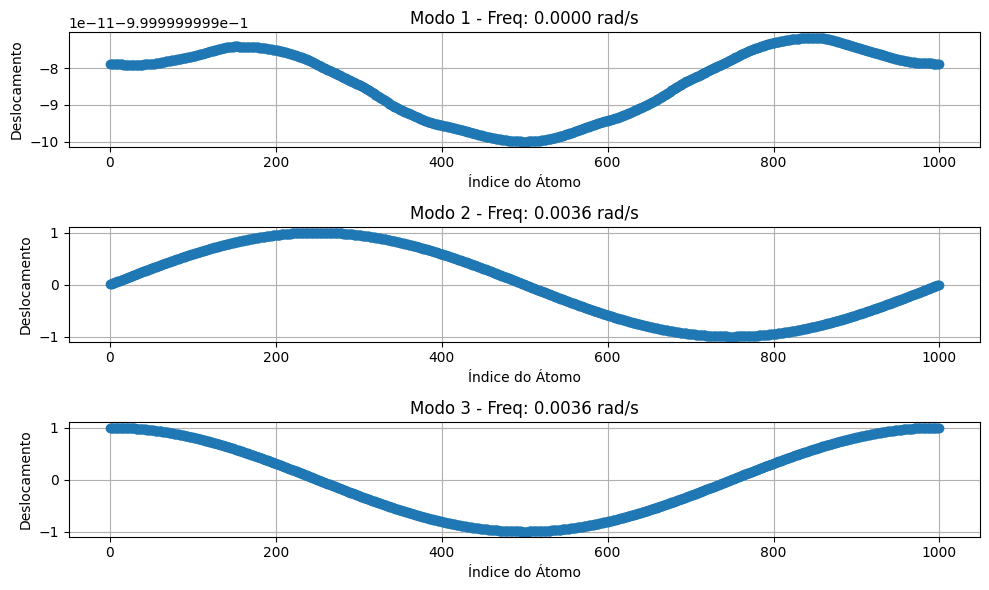

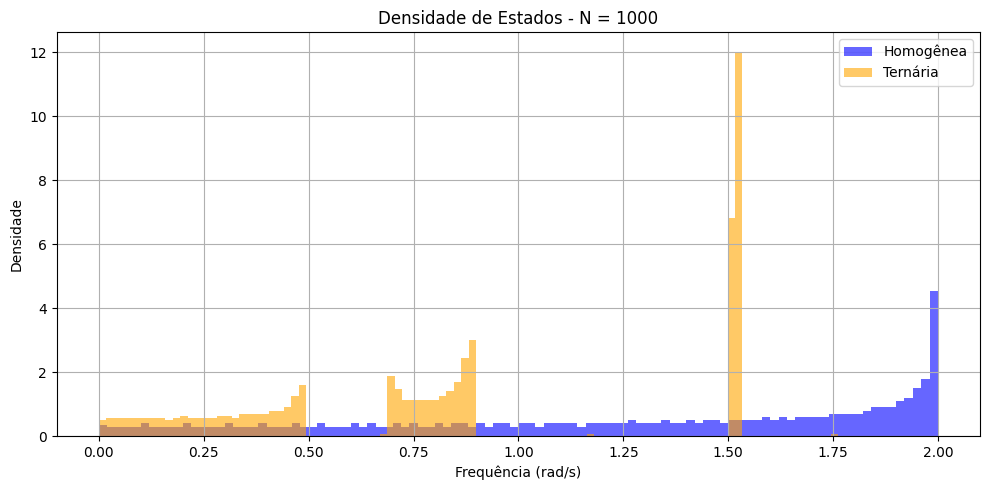


===== N = 10000 =====
Homogênea - Primeiras 5 frequências: [1.41134000e-08 6.28318520e-04 6.28318521e-04 1.25663698e-03
 1.25663698e-03]
Ternária - Primeiras 5 frequências: [0.         0.00036276 0.00036278 0.00072552 0.00072557]


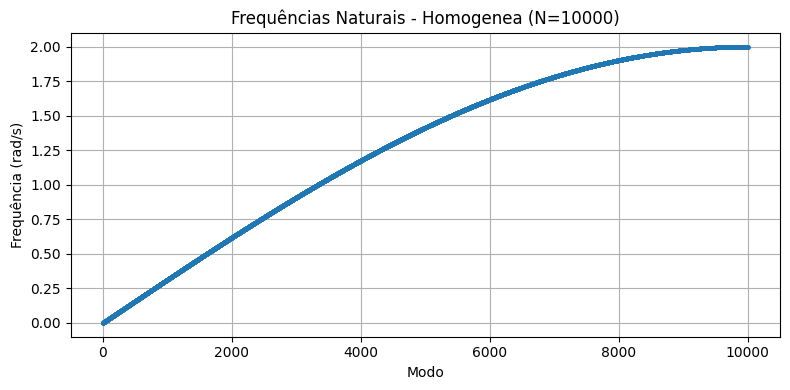

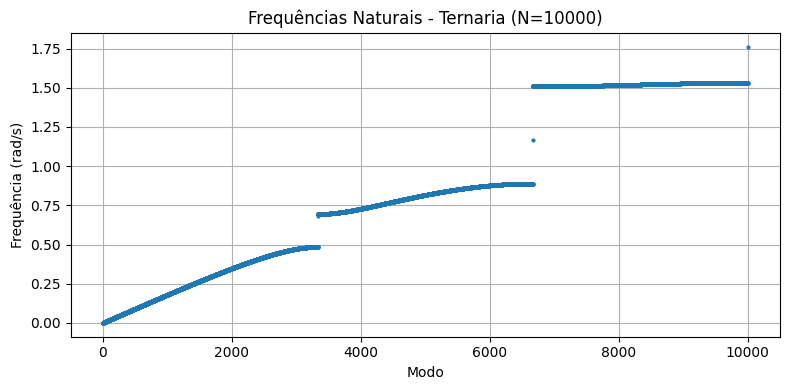

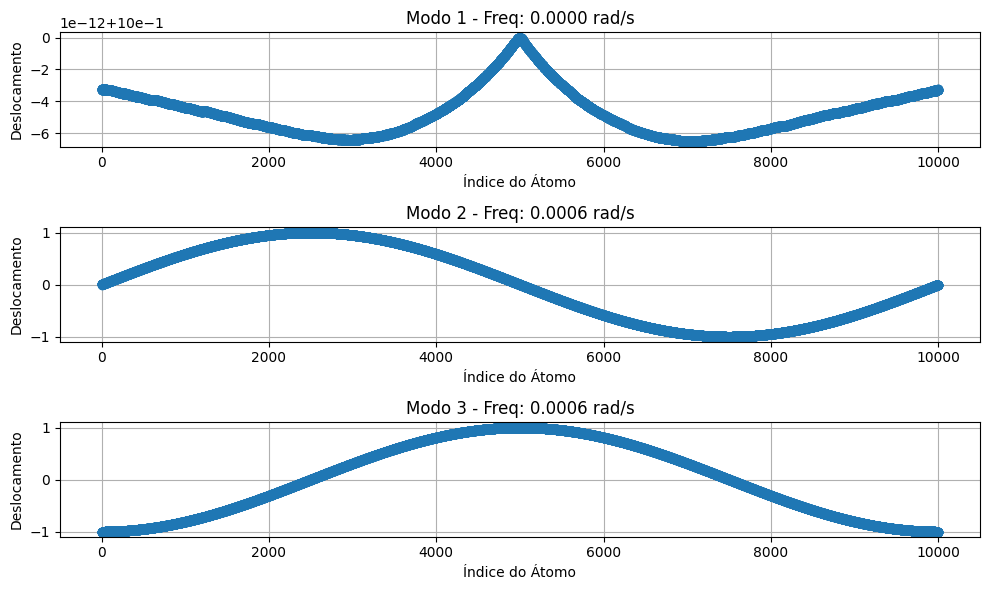

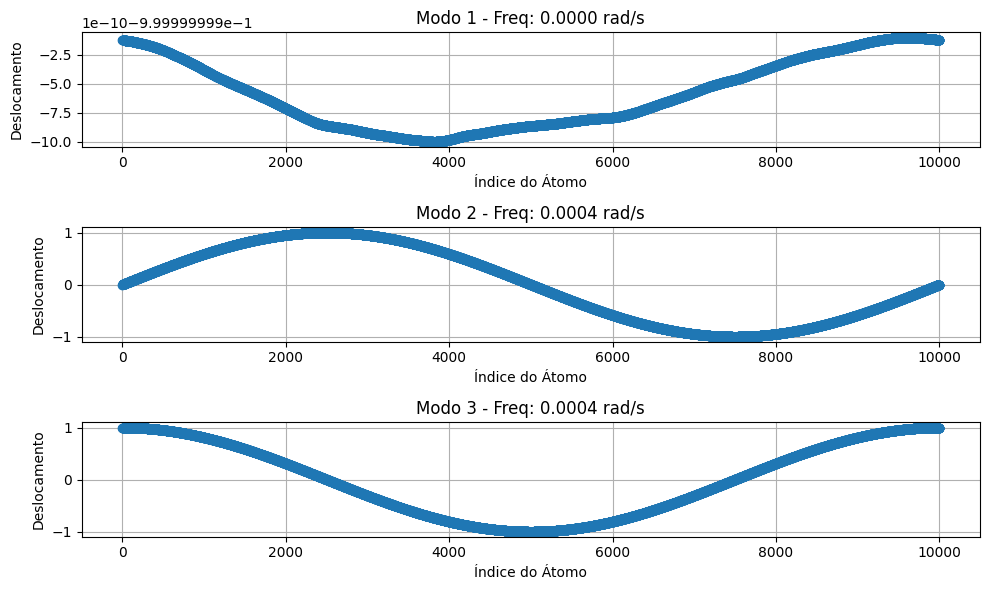

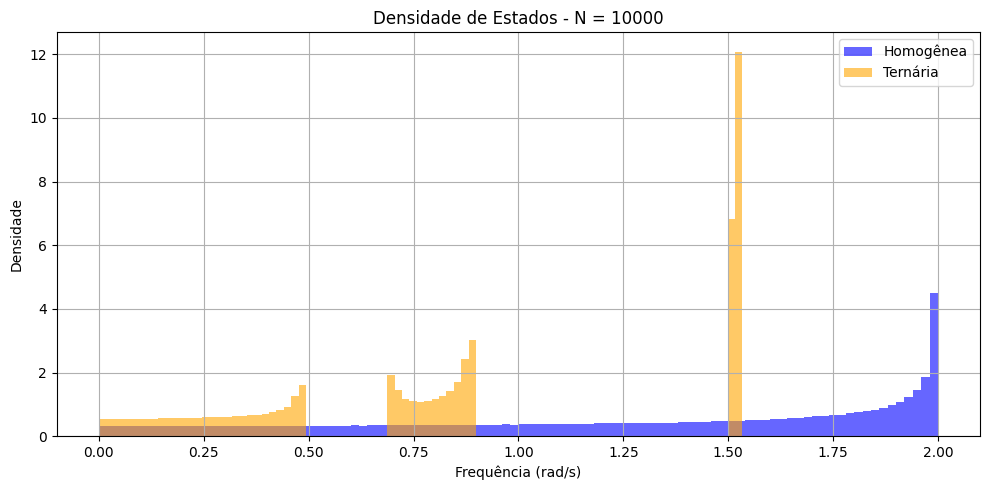

In [9]:
Ns = [100, 1000, 10000]

for N in Ns:
    print(f"\n===== N = {N} =====")

    # Homogênea
    sistema_hom = CadeiaAtomica(N=N, tipo='homogenea', k=1.0)
    freq_hom, modos_hom = sistema_hom.calcular_frequencias_e_modos()
    print("Homogênea - Primeiras 5 frequências:", freq_hom[:5])

    # Ternária
    sistema_tern = CadeiaAtomica(N=N, tipo='ternaria', k=1.0)
    freq_tern, modos_tern = sistema_tern.calcular_frequencias_e_modos()
    print("Ternária - Primeiras 5 frequências:", freq_tern[:5])

    # Plota frequências individuais
    sistema_hom.plotar_frequencias(freq_hom)
    sistema_tern.plotar_frequencias(freq_tern)

    # Plota os primeiros 3 modos normais
    sistema_hom.plotar_modos_normais(modos_hom, freq_hom)
    sistema_tern.plotar_modos_normais(modos_tern, freq_tern)

    # Plota comparação da densidade de estados
    plotar_densidade_de_estados(freq_hom, freq_tern, N, bins=100)


### Exercício 03
![alt text](ex3.png)

In [10]:
def plotar_modos_extremos(modos, freq, N, tipo, n_modos=5):
    plt.figure(figsize=(14, 10))

    # Índices das 5 menores e 5 maiores frequências
    indices_menores = np.argsort(freq)[:n_modos]
    indices_maiores = np.argsort(freq)[-n_modos:]

    # Plot dos modos de menor frequência
    for i, idx in enumerate(indices_menores):
        desloc = modos[:, idx]
        desloc /= np.max(np.abs(desloc))
        plt.subplot(2, n_modos, i + 1)
        plt.plot(desloc, marker='.')
        plt.title(f"Menor Modo {i+1} - Freq: {freq[idx]:.4f} rad/s")
        plt.xlabel("Átomo")
        plt.ylabel("Desloc.")
        plt.grid(True)

    # Plot dos modos de maior frequência
    for i, idx in enumerate(indices_maiores):
        desloc = modos[:, idx]
        desloc /= np.max(np.abs(desloc))
        plt.subplot(2, n_modos, n_modos + i + 1)
        plt.plot(desloc, marker='.')
        plt.title(f"Maior Modo {i+1} - Freq: {freq[idx]:.4f} rad/s")
        plt.xlabel("Átomo")
        plt.ylabel("Desloc.")
        plt.grid(True)

    plt.suptitle(f"Modos Normais Extremos - {tipo.capitalize()} (N={N})", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



===== N = 100 =====
Homogênea - Primeiras 5 frequências: [0.         0.06282152 0.06282152 0.12558104 0.12558104]
Ternária - Primeiras 5 frequências: [0.         0.03626251 0.03650637 0.07244376 0.0729339 ]


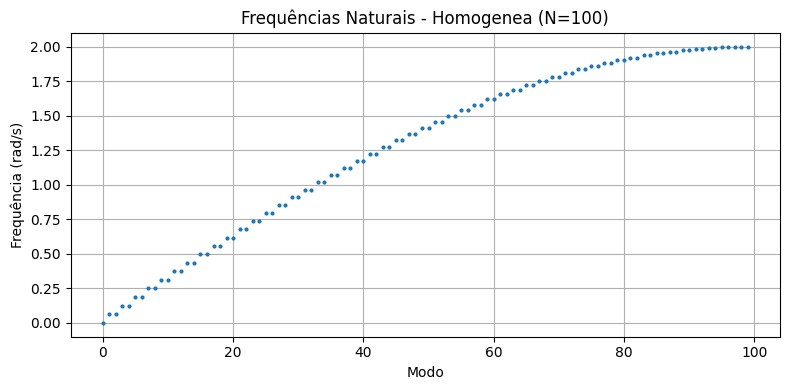

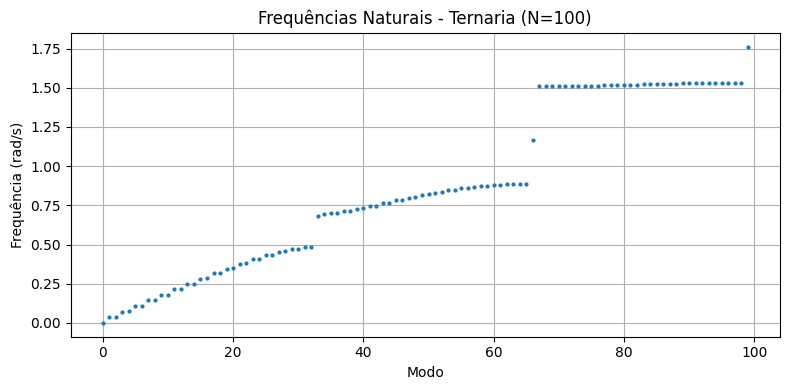

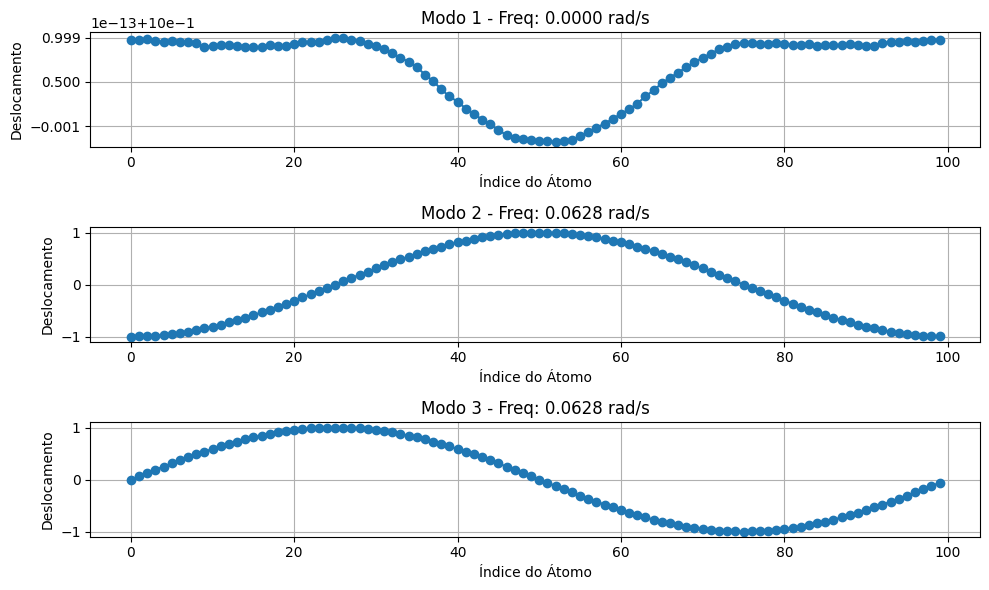

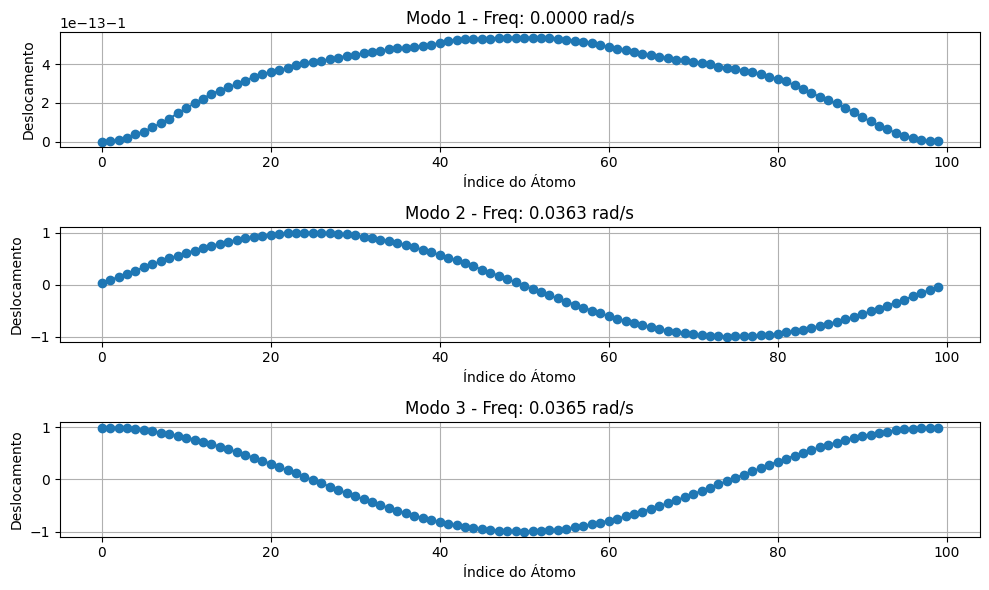

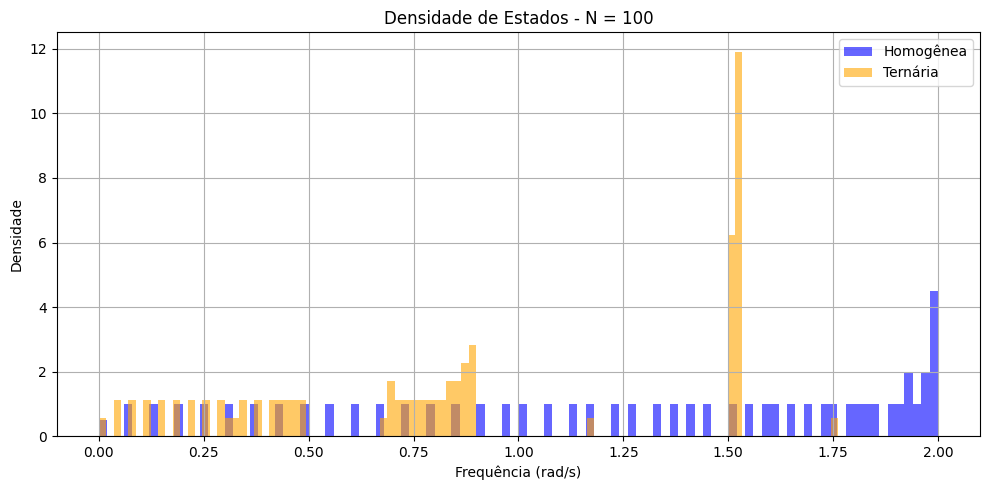

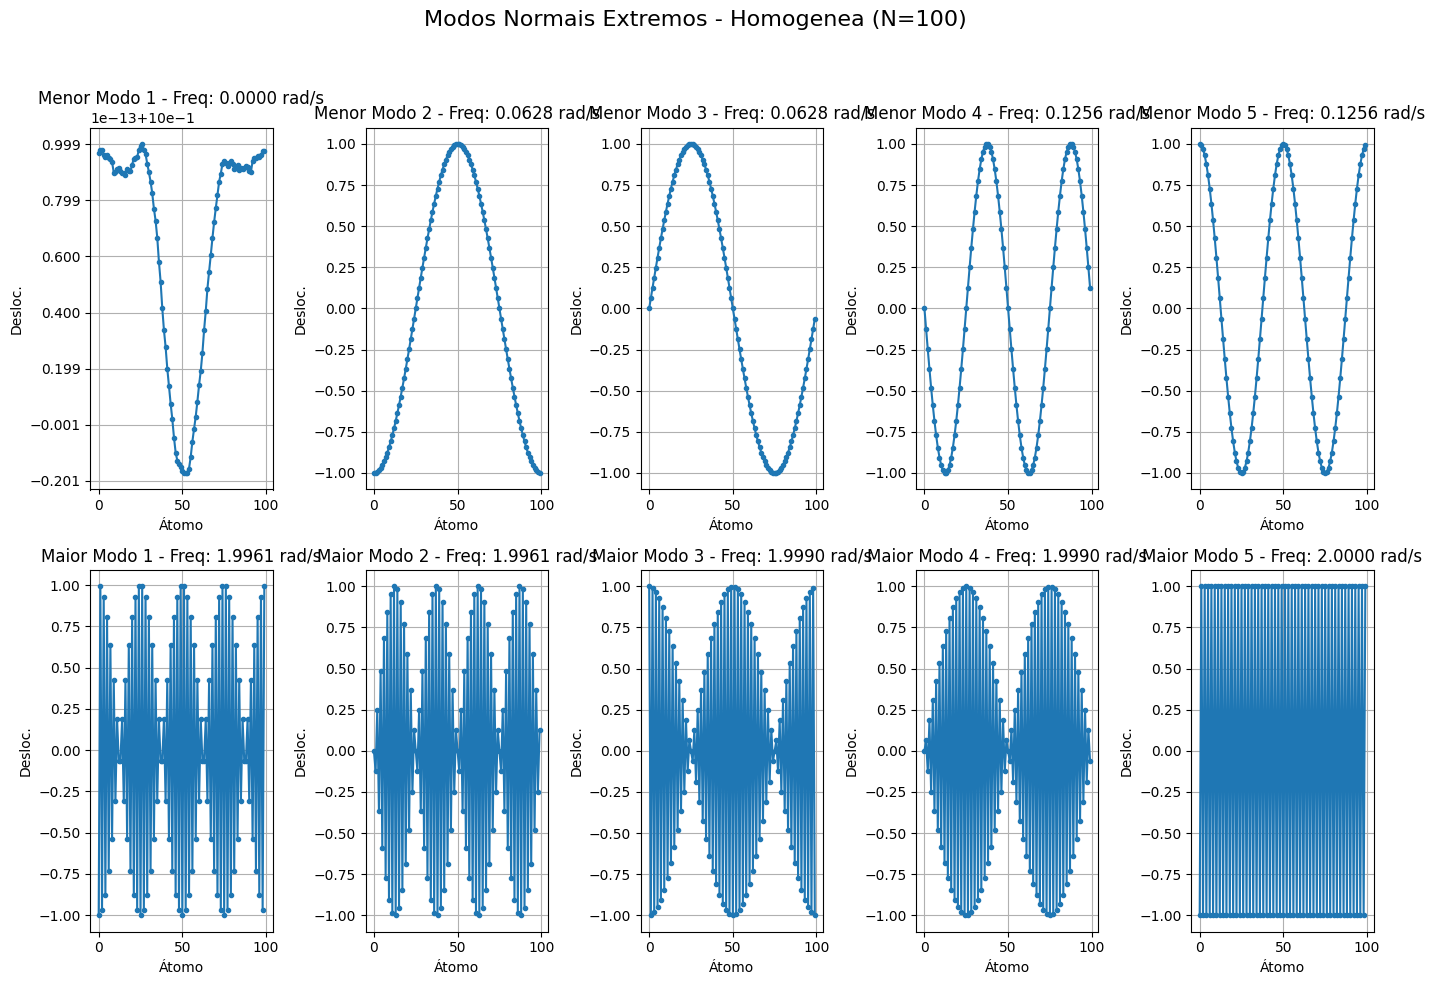

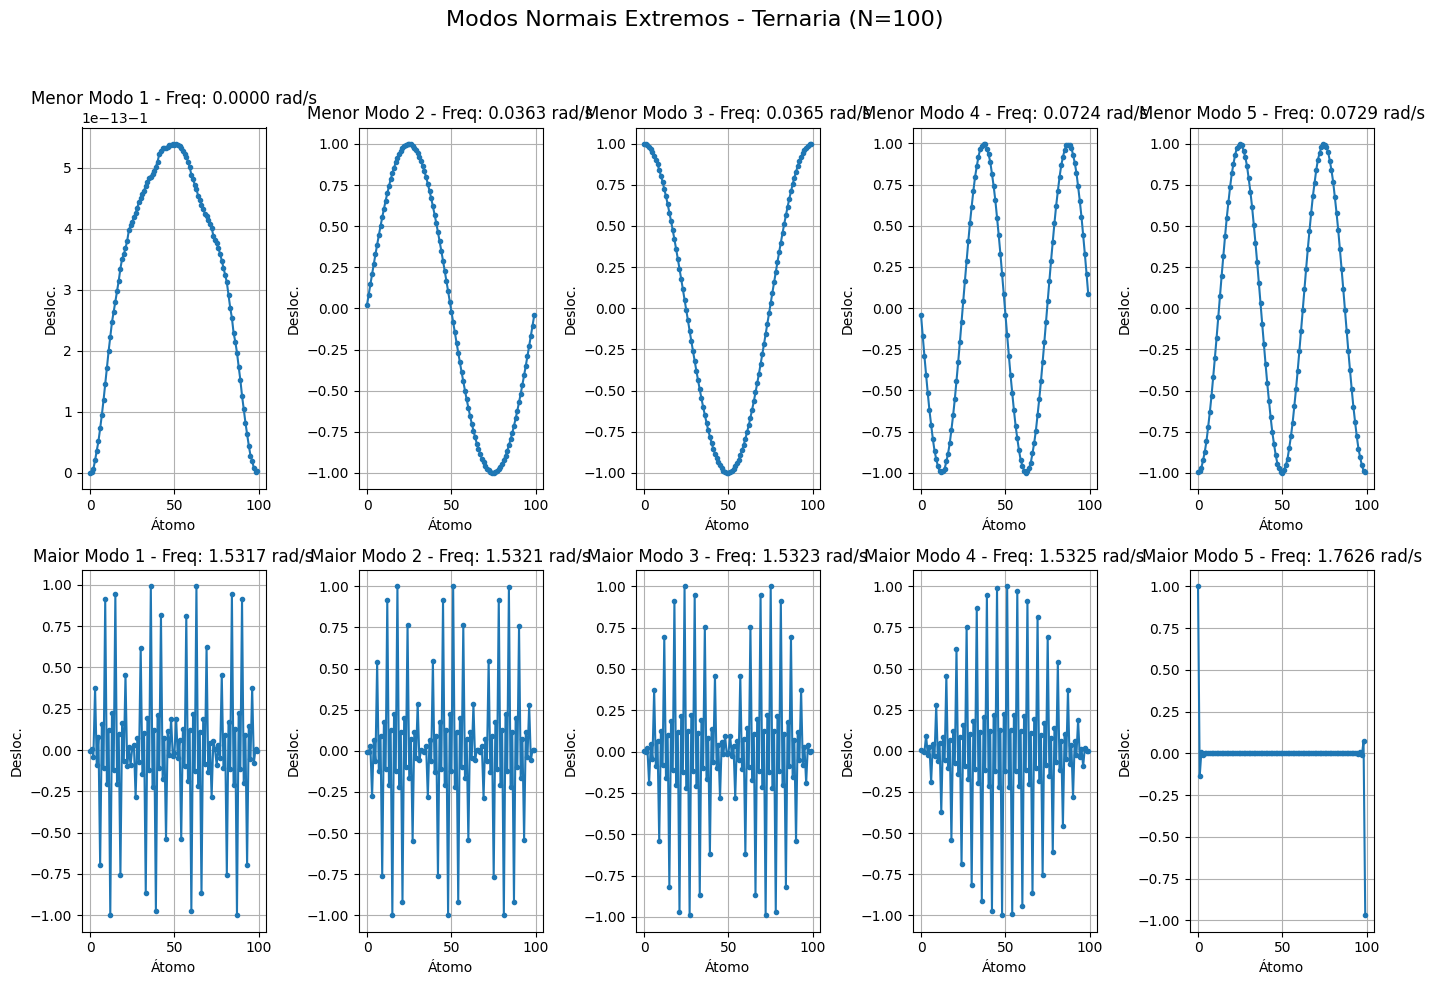


===== N = 1000 =====
Homogênea - Primeiras 5 frequências: [2.52890835e-08 6.28317497e-03 6.28317497e-03 1.25662879e-02
 1.25662879e-02]
Ternária - Primeiras 5 frequências: [0.         0.00362759 0.00363001 0.00725509 0.00725993]


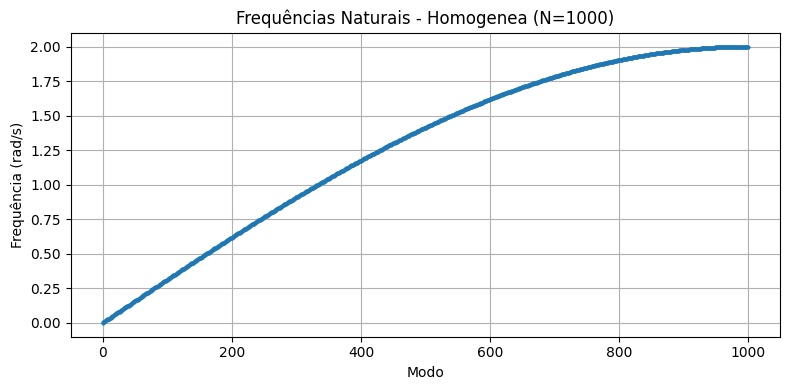

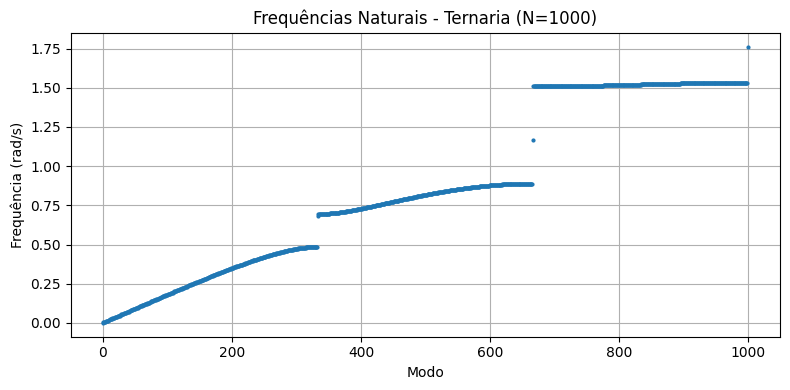

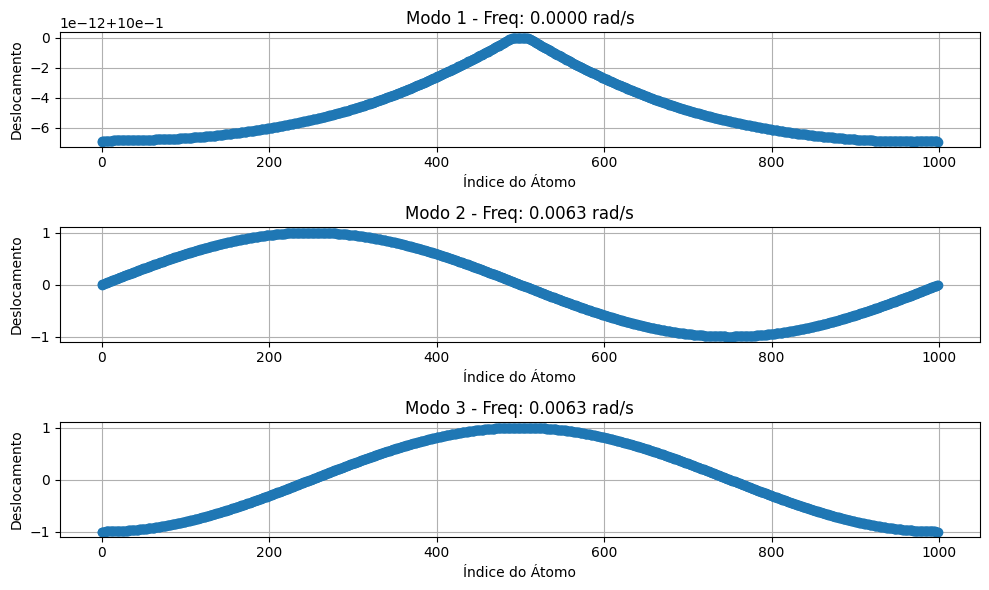

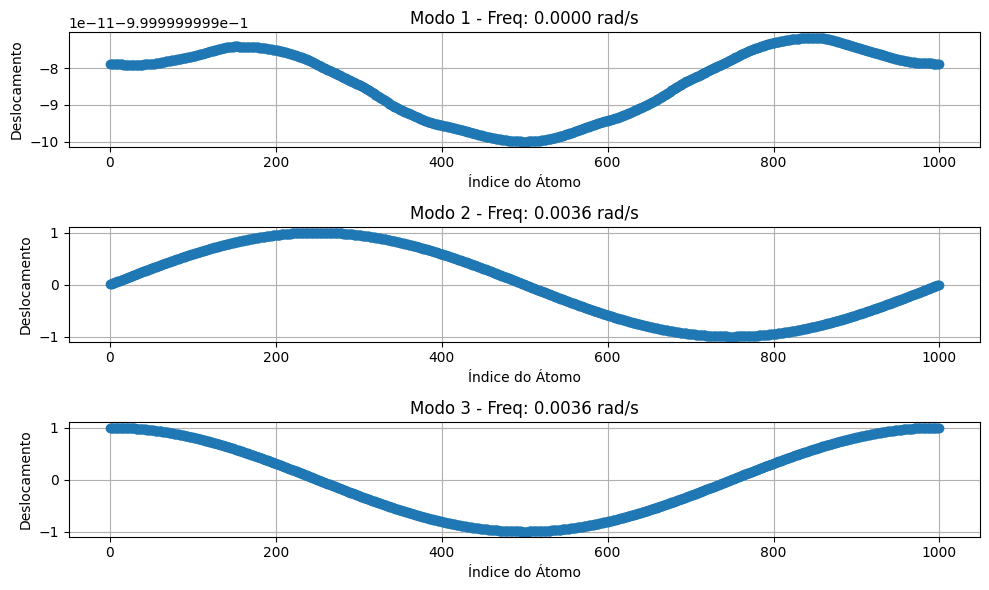

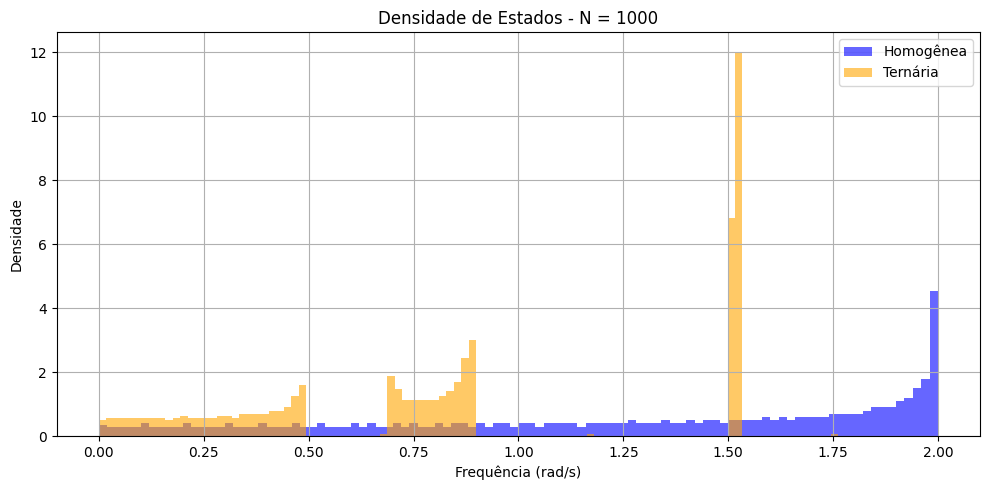

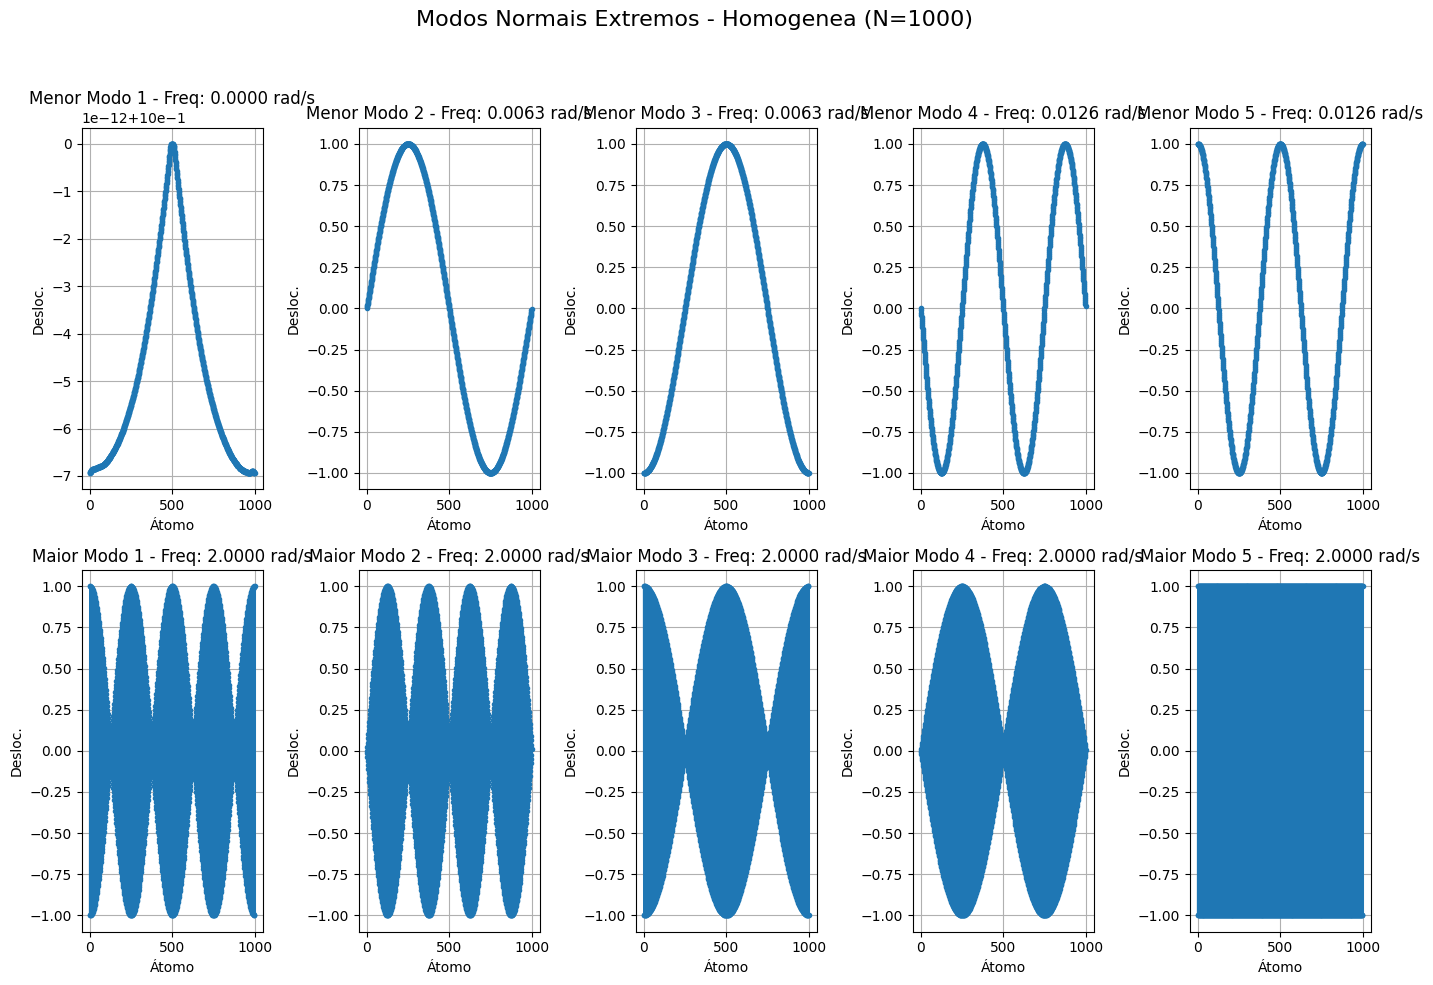

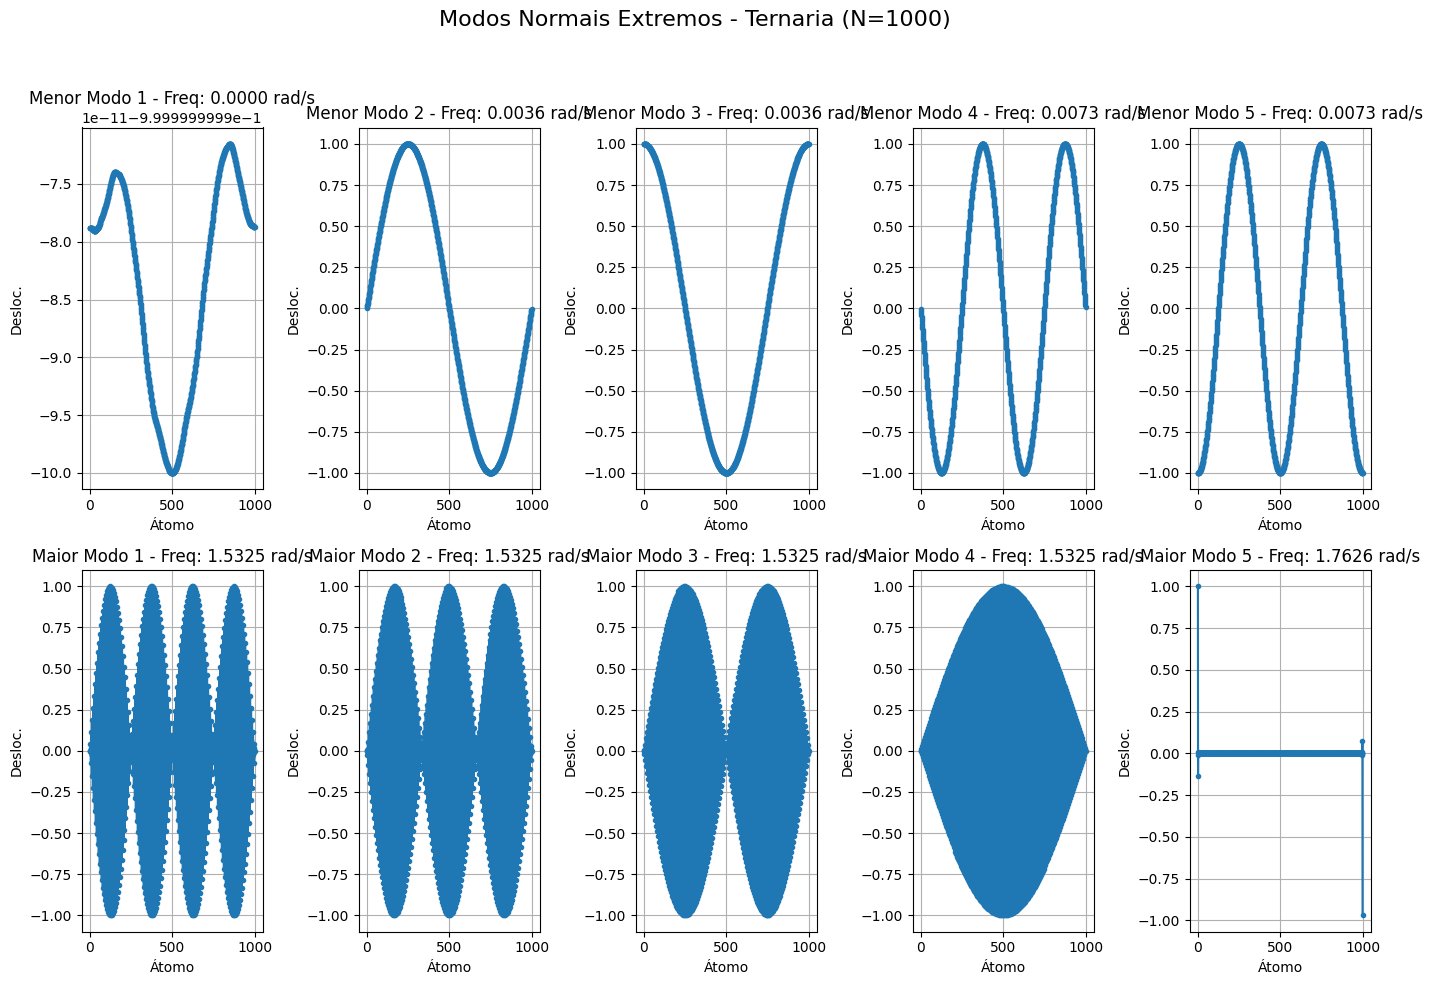


===== N = 10000 =====
Homogênea - Primeiras 5 frequências: [1.41134000e-08 6.28318520e-04 6.28318521e-04 1.25663698e-03
 1.25663698e-03]
Ternária - Primeiras 5 frequências: [0.         0.00036276 0.00036278 0.00072552 0.00072557]


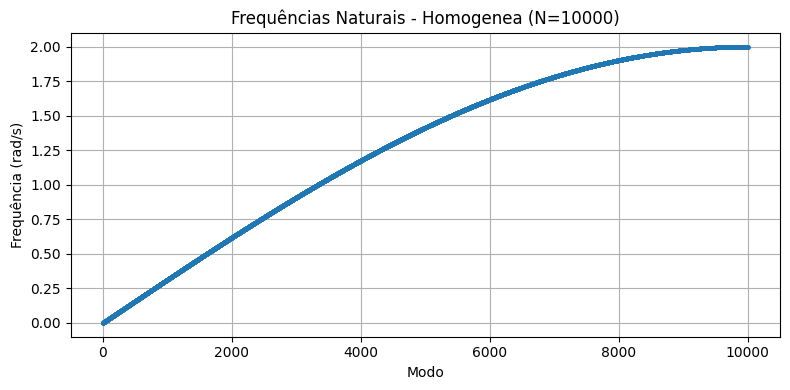

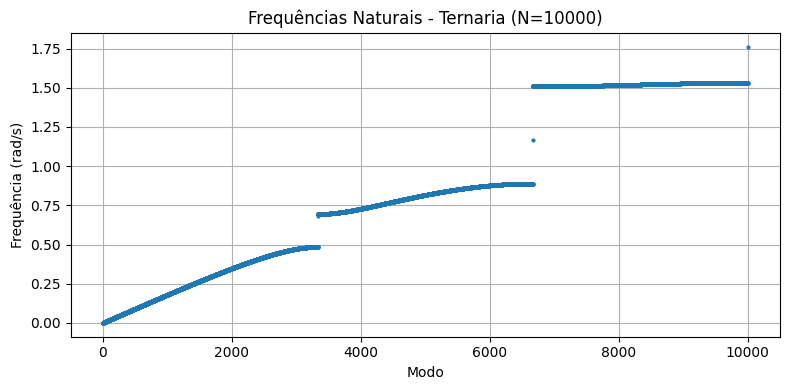

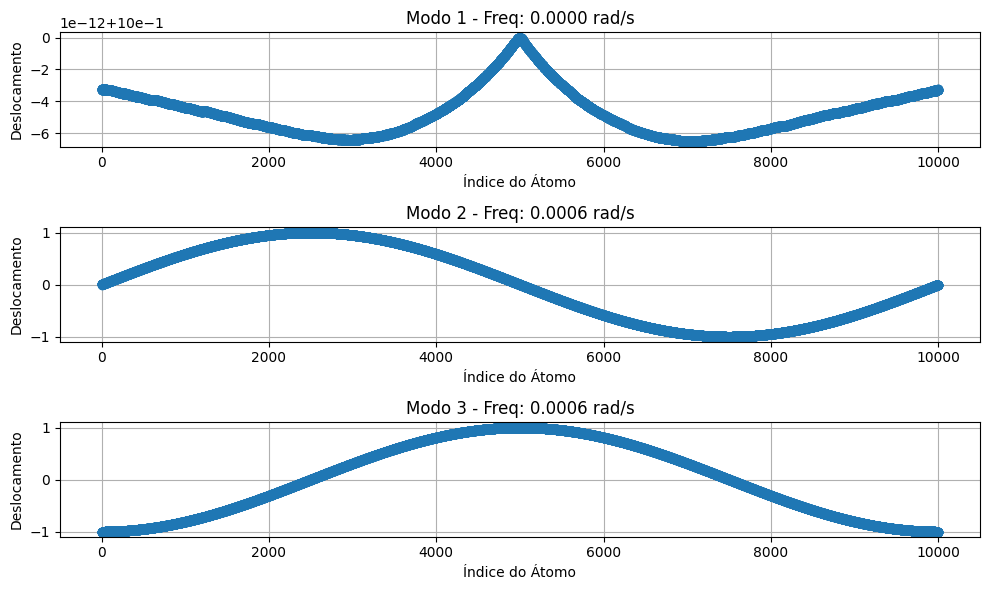

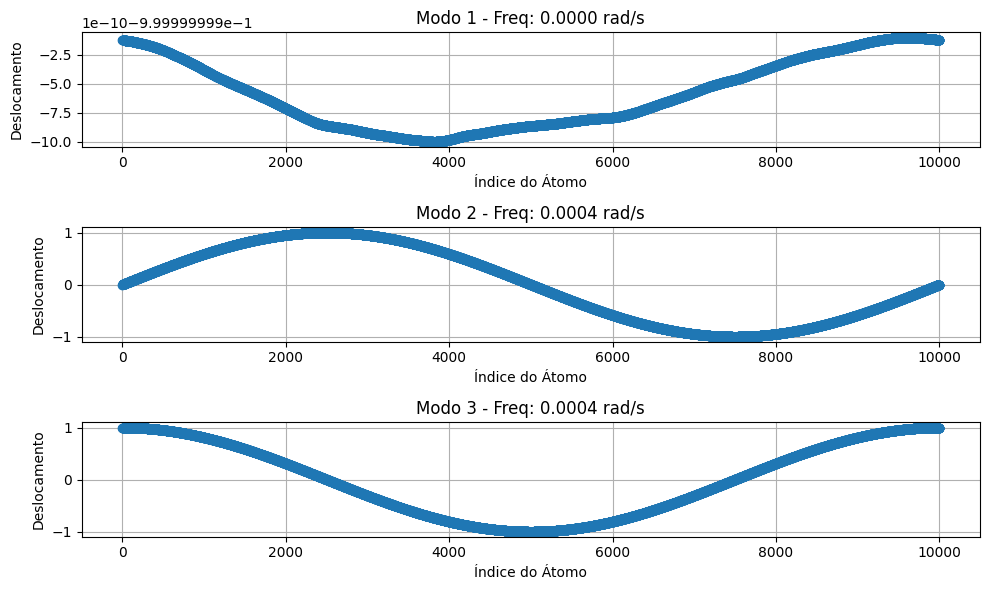

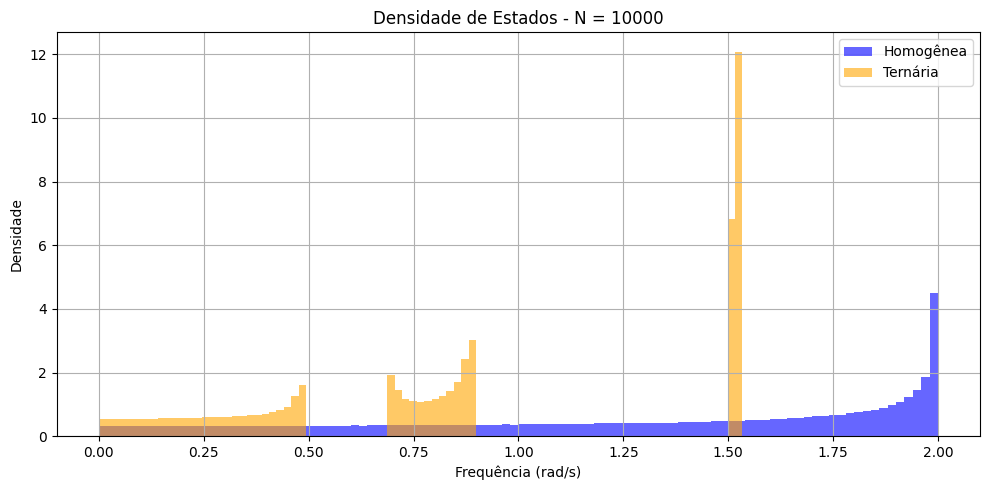

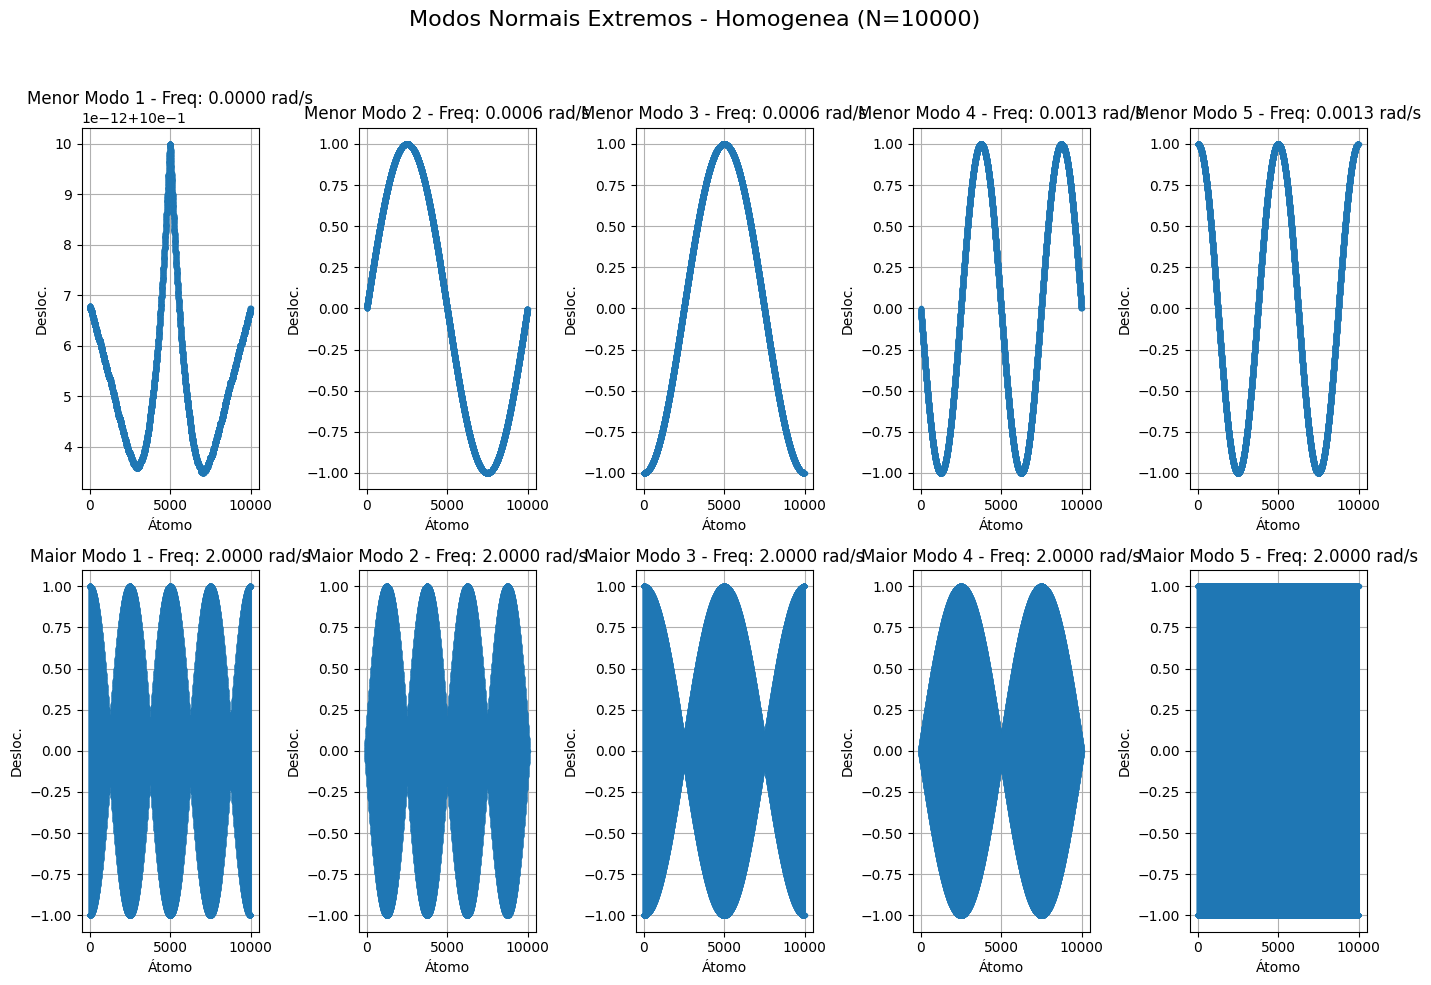

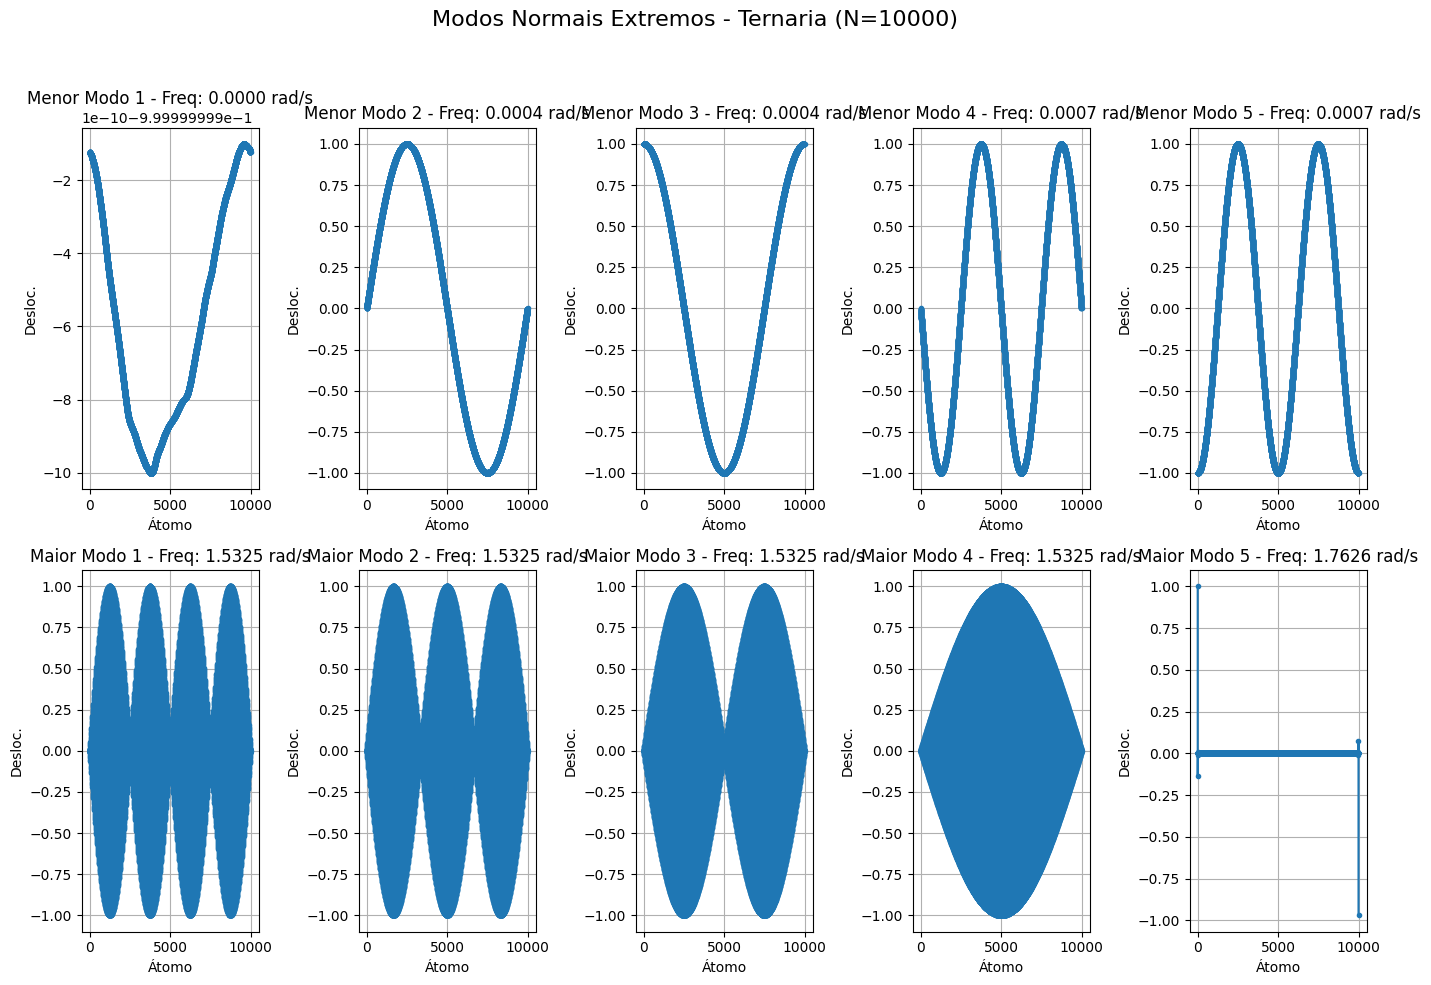

In [11]:
Ns = [100, 1000, 10000]

for N in Ns:
    print(f"\n===== N = {N} =====")

    # Homogênea
    sistema_hom = CadeiaAtomica(N=N, tipo='homogenea', k=1.0)
    freq_hom, modos_hom = sistema_hom.calcular_frequencias_e_modos()
    print("Homogênea - Primeiras 5 frequências:", freq_hom[:5])

    # Ternária
    sistema_tern = CadeiaAtomica(N=N, tipo='ternaria', k=1.0)
    freq_tern, modos_tern = sistema_tern.calcular_frequencias_e_modos()
    print("Ternária - Primeiras 5 frequências:", freq_tern[:5])

    # Plota frequências
    sistema_hom.plotar_frequencias(freq_hom)
    sistema_tern.plotar_frequencias(freq_tern)

    # Plota os 3 primeiros modos normais
    sistema_hom.plotar_modos_normais(modos_hom, freq_hom)
    sistema_tern.plotar_modos_normais(modos_tern, freq_tern)

    # Densidade de estados
    plotar_densidade_de_estados(freq_hom, freq_tern, N, bins=100)

    # Modos normais extremos (baixa e alta energia)
    plotar_modos_extremos(modos_hom, freq_hom, N, tipo='homogenea')
    plotar_modos_extremos(modos_tern, freq_tern, N, tipo='ternaria')


### Exercício 04
![alt text](ex4.png)

## 4. Análise e Comparação

A seguir, apresentamos uma análise comparativa entre a cadeia **homogênea** (todas as massas iguais a \( m \)) e a cadeia **ternária** (massas alternando entre \( m,\ 3m,\ 5m \)) em relação às frequências naturais de vibração, densidade de estados e padrões de deslocamento dos modos normais.

### 📌 4.1 Distribuição das Frequências (Densidade de Estados)

**Cadeia Homogênea:**
- Apresenta uma distribuição de frequências contínua e suave.
- A forma da curva de densidade de estados é típica de sistemas com simetria translacional uniforme.
- As frequências estão densamente distribuídas dentro de uma única banda contínua.

**Cadeia Ternária:**
- A distribuição das frequências apresenta **lacunas (band gaps)** visíveis entre grupos de frequências.
- Essas bandas surgem devido à alternância de massas, que quebra a simetria simples do sistema.
- A densidade de estados é composta por múltiplas faixas separadas, o que caracteriza o surgimento de zonas proibidas de vibração.

**Conclusão:**  
> A alternância de massas na cadeia ternária introduz **band gaps** na densidade de estados — algo que **não ocorre** na cadeia homogênea. Esse comportamento é análogo à formação de bandas proibidas em sólidos cristalinos com múltiplos átomos por célula unitária.


### 📌 4.2 Padrões de Deslocamento dos Modos Normais

**Modos de Baixa Frequência (baixa energia):**
- Em ambas as cadeias, os modos de baixa frequência apresentam **movimentos coletivos** e suaves, com muitos átomos vibrando em fase.
- Esses modos se assemelham a ondas acústicas de baixa energia.

**Modos de Alta Frequência (alta energia):**
- Na cadeia homogênea, os modos de alta frequência são contínuos, com rápida oscilação dos átomos ao longo da cadeia.
- Na cadeia ternária, os modos de alta frequência apresentam **localização espacial**: certos átomos vibram com amplitude maior, enquanto outros permanecem quase imóveis.

**Localização dos Modos:**
- A estrutura ternária favorece a **localização vibracional** em regiões específicas da cadeia, especialmente nas massas mais leves.
- A heterogeneidade introduzida pelas diferentes massas impede o espalhamento uniforme da energia vibracional.

**Conclusão:**  
> A cadeia homogênea apresenta modos normais mais distribuídos e contínuos, enquanto a cadeia ternária exibe **modos localizados**, especialmente nos de alta frequência, devido à diferença de inércia entre as massas \( m,\ 3m,\ 5m \).

### 📌 4.3 Lacunas de Frequência (Band Gaps)

**Cadeia Homogênea:**
- Não há lacunas de frequência. As frequências cobrem uma faixa contínua desde zero até uma frequência máxima.

**Cadeia Ternária:**
- Apresenta lacunas de frequência visíveis entre bandas de modos vibracionais.
- Essas **band gaps** são resultado direto da estrutura periódica com múltiplas massas diferentes, o que cria zonas proibidas de propagação de certos modos.

**Conclusão:**  
> A cadeia ternária apresenta **band gaps claramente identificáveis**, que se tornam mais evidentes à medida que \( N \) aumenta. Esses fenômenos são importantes na modelagem de cristais, isolantes e dispositivos fonônicos.

### ✅ Resumo Comparativo

| Característica                    | Cadeia Homogênea              | Cadeia Ternária                      |
|----------------------------------|-------------------------------|--------------------------------------|
| Distribuição das Frequências     | Contínua e suave              | Em bandas, com lacunas (band gaps)   |
| Modos de Baixa Frequência        | Ondas coletivas suaves        | Ondas suaves com perturbações leves  |
| Modos de Alta Frequência         | Oscilações rápidas contínuas  | Modos **localizados** por inércia    |
| Lacunas de Frequência            | Não existem                   | Sim, existem lacunas visíveis        |
| Localização Vibracional          | Pouco ou nenhum               | Presente nos modos de alta energia   |

resposta do moodle:

Introdução

O modelo massa-mola é uma representação simplificada, porém eficaz, das interações atômicas em sólidos, onde massas simulam átomos e molas representam forças de ligação entre eles. Esse modelo permite estudar a propagação de vibrações e ondas mecânicas em sistemas discretos.

Cadeias homogêneas, compostas por massas e molas idênticas, refletem materiais com estrutura uniforme. Já cadeias binárias, com alternância de massas e/ou molas, simulam materiais compostos e revelam fenômenos como bandas proibidas na propagação de ondas.

As condições de contorno livres, onde as extremidades da cadeia não estão fixas, são importantes para representar sistemas físicos reais, como superfícies de cristais ou nanoestruturas. Elas influenciam diretamente os modos normais de vibração e permitem uma análise mais realista do comportamento dinâmico do sistema.